# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [1]:
!pip install pandas_ta
!pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=092795bd3a94053009a497867419dbda0b78e1ee3b55b53bc0797c8ee3cc0538
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.9/218.9 kB 10.5 MB/s eta 0:00:00


## 1. Download/Load SP500 stocks prices data.

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-12-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[**********************69%********               ]  346 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**********************70%*********              ]  352 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**********************99%***********************]  499 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**********************99%***********************]  500 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSCO']: YFPricesMissingError('$%ticker%: possibly delisted; no pric

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-29 A        42.944069   45.639999   46.000000   45.570000   45.680000   
           AAPL     27.026247   29.182501   29.277500   29.100000   29.112499   
           ABBV     44.492252   62.730000   63.060001   62.389999   62.389999   
           ABT      33.147766   38.310001   38.509998   38.110001   38.299999   
           ACGL     28.696667   28.696667   28.809999   28.536667   28.610001   
...                       ...         ...         ...         ...         ...   
2024-12-26 XYL     118.470001  118.470001  118.720001  117.540001  117.800003   
           YUM     136.000000  136.000000  136.800003  134.199997  134.350006   
           ZBH     107.009148  107.250000  108.120003  106.610001  107.000000   
           ZBRA    396.850006  396.850006  397.500000  392.109985  392.269989   
           ZTS     165.520004  165.520004  165.789993  163.020004  163.720001   

Price                  volume  
date       ticker              
2016-12-29 A         891000.0  
           AAPL    60158000.0  
           ABBV     4990000.0  
           ABT      7050800.0  
           ACGL      731100.0  
...                       ...  
2024-12-26 XYL       575700.0  
           YUM      1040900.0  
           ZBH      1277300.0  
           ZBRA      140100.0  
           ZTS      2167200.0  

[989702 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [3]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-12-29 A        42.944069   45.639999   46.000000   45.570000   45.680000   
           AAPL     27.026247   29.182501   29.277500   29.100000   29.112499   
           ABBV     44.492252   62.730000   63.060001   62.389999   62.389999   
           ABT      33.147766   38.310001   38.509998   38.110001   38.299999   
           ACGL     28.696667   28.696667   28.809999   28.536667   28.610001   
...                       ...         ...         ...         ...         ...   
2024-12-26 XYL     118.470001  118.470001  118.720001  117.540001  117.800003   
           YUM     136.000000  136.000000  136.800003  134.199997  134.350006   
           ZBH     107.009148  107.250000  108.120003  106.610001  107.000000   
           ZBRA    396.850006  396.850006  397.500000  392.109985  392.269989   
           ZTS     165.520004  165.520004  165.789993  163.020004  163.720001   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-12-29 A         891000.0         -0.001429        NaN       NaN   
           AAPL    60158000.0         -0.002117        NaN       NaN   
           ABBV     4990000.0         -0.044098        NaN       NaN   
           ABT      7050800.0         -0.008009        NaN       NaN   
           ACGL      731100.0          0.000042        NaN       NaN   
...                       ...               ...        ...       ...   
2024-12-26 XYL       575700.0          0.000037  38.652872  4.747645   
           YUM      1040900.0          0.000127  51.828757  4.884407   
           ZBH      1277300.0          0.000099  47.670324  4.657201   
           ZBRA      140100.0          0.000041  52.110783  5.956002   
           ZTS      2167200.0          0.000096  36.061861  5.094538   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-12-29 A            NaN       NaN       NaN       NaN      38.263165  
           AAPL         NaN       NaN       NaN       NaN    1625.844969  
           ABBV         NaN       NaN       NaN       NaN     222.016339  
           ABT          NaN       NaN       NaN       NaN     233.718269  
           ACGL         NaN       NaN       NaN       NaN      20.980133  
...                     ...       ...       ...       ...            ...  
2024-12-26 XYL     4.818183  4.888722  0.506754 -1.562754      68.203180  
           YUM     4.922677  4.960947  0.619214 -0.496232     141.562400  
           ZBH     4.691991  4.726781 -0.600698 -0.273378     136.682784  
           ZBRA    5.997550  6.039098  0.000369 -0.152269      55.598686  
           ZTS     5.157927  5.221317  0.414887 -1.639641     358.714953  

[989702 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [4]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-02-28 A           98.277655   48.269749         -0.001607  63.782548   
           AAPL      3730.197028   31.854513         -0.002049  87.858946   
           ABBV       293.042512   44.303555         -0.044025  53.224152   
           ABT        332.530632   39.257492         -0.008100  76.196534   
           ACGL        36.285420   31.523333          0.000039  76.306765   
...                          ...         ...               ...        ...   
2024-12-31 KVUE       288.721590   21.719999          0.000077  38.301629   
           VLTO       141.155517  103.757996          0.000054  46.090633   
           GEV       1050.962718  343.070007          0.000179  56.448973   
           SOLV        57.202885   66.940002          0.000155  40.692070   
           SW         179.512032   54.150002          0.000082  55.147365   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-02-28 A       3.844027  3.881775  3.919523 -1.557997  0.293664  
           AAPL    3.400463  3.462253  3.524044 -1.456204  0.117520  
           ABBV    3.784567  3.803218  3.821869 -1.771328 -0.216259  
           ABT     3.609819  3.664647  3.719474 -1.552262  0.663475  
           ACGL    3.422038  3.460980  3.499921 -1.180559  0.355150  
...                     ...       ...       ...       ...       ...  
2024-12-31 KVUE    3.085104  3.158970  3.232836 -0.195182 -1.074864  
           VLTO    4.625433  4.663444  4.701456  0.011354 -1.341096  
           GEV     5.774915  5.822109  5.869304  1.946098 -0.555236  
           SOLV    4.199196  4.252046  4.304896 -1.431480 -0.795481  
           SW      3.969262  4.007092  4.044923 -0.773805 -0.057498  

[46750 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [5]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-01-31 AAPL     39.388073         -0.001208  40.100597  3.695993   
           ABBV     83.089928         -0.042428  62.305712  4.236627   
           ABT      55.294987         -0.005933  69.274795  3.936873   
           ACN     144.842697         -0.003841  63.135420  4.952747   
           ADBE    199.759995          0.000156  65.801042  5.203949   
...                       ...               ...        ...       ...   
2024-12-31 UBER     61.560001          0.000086  36.707972  4.044583   
           CRWD    365.079987          0.000082  56.136610  5.829083   
           PLTR     82.139999          0.000294  71.683942  4.185113   
           ABNB    135.320007          0.000088  51.027493  4.866939   
           KVUE     21.719999          0.000077  38.301629  3.085104   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-01-31 AAPL    3.736405  3.776816 -1.246528 -0.430040  
           ABBV    4.368567  4.500507  1.179613  1.689173  
           ABT     3.995678  4.054483 -0.925023  0.888201  
           ACN     4.976202  4.999657 -1.246239  0.243560  
           ADBE    5.268046  5.332143 -1.283856  0.406553  
...                     ...       ...       ...       ...  
2024-12-31 UBER    4.182097  4.319611  0.633100 -2.128275  
           CRWD    5.888615  5.948147  1.526468  0.656669  
           PLTR    4.312314  4.439515  4.393466  3.839448  
           ABNB    4.914160  4.961380 -0.777241 -0.125526  
           KVUE    3.158970  3.232836 -0.195182 -1.074864  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [6]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-01-31 AAPL     39.743023         -0.000391  53.482537  3.564609   
           ABBV     62.078793         -0.021799  41.951135  4.108503   
           ABT      66.100258         -0.001865  56.879235  4.115729   
           ACN     140.895660         -0.002769  55.082741  4.855345   
           ADBE    247.820007          0.000148  56.084696  5.412191   
...                       ...               ...        ...       ...   
2024-12-31 MRNA     40.430000          0.000356  40.601134  3.670252   
           UBER     61.560001          0.000086  36.707972  4.044583   
           CRWD    365.079987          0.000082  56.136610  5.829083   
           PLTR     82.139999          0.000294  71.683942  4.185113   
           ABNB    135.320007          0.000088  51.027493  4.866939   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-01-31 AAPL    3.630896  3.697183 -0.865626 -0.381171   0.055154   
           ABBV    4.201370  4.294236  0.343455 -1.043381  -0.118399   
           ABT     4.161145  4.206561 -0.065967  0.139833   0.013665   
           ACN     4.915819  4.976293 -0.769556  0.043044   0.088930   
           ADBE    5.478527  5.544863 -0.672298  0.203190   0.095385   
...                     ...       ...       ...       ...        ...   
2024-12-31 MRNA    3.756965  3.843678 -0.767482 -0.203951  -0.061078   
           UBER    4.182097  4.319611  0.633100 -2.128275  -0.144525   
           CRWD    5.888615  5.948147  1.526468  0.656669   0.055236   
           PLTR    4.312314  4.439515  4.393466  3.839448   0.224508   
           ABNB    4.914160  4.961380 -0.777241 -0.125526  -0.005804   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-01-31 AAPL    -0.034589  -0.086165  -0.020933   0.001996    0.000748  
           ABBV    -0.071480   0.014454  -0.019116  -0.016684   -0.024001  
           ABT     -0.004952   0.020737   0.019565   0.027107    0.014985  
           ACN     -0.033914  -0.008682  -0.004631   0.002728   -0.002300  
           ADBE    -0.006137   0.002786   0.002128   0.012503    0.018128  
...                      ...        ...        ...        ...         ...  
2024-12-31 MRNA    -0.137593  -0.154246  -0.164374  -0.102087   -0.072263  
           UBER    -0.075659  -0.064370  -0.027296  -0.024545   -0.000014  
           CRWD     0.108947   0.091861  -0.008037   0.014544    0.030248  
           PLTR     0.405852   0.302179   0.215123   0.147142    0.135549  
           ABNB     0.001964   0.021887  -0.018788  -0.021766   -0.000503  

[10361 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [7]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-01-31 AAPL     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.055154
           ABBV     0.084  0.0301 -0.0045 -0.0078 -0.0152  -0.118399
           ABT      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.013665
           ACN      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.088930
           ADBE     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.095385
...                   ...     ...     ...     ...     ...        ...
2024-11-30 VZ       0.065  0.0478 -0.0005 -0.0261 -0.0217   0.052457
           WDAY     0.065  0.0478 -0.0005 -0.0261 -0.0217   0.069019
           WFC      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.180051
           WMT      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.128580
           XOM      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.010104

[10220 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [8]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-01-31 AAPL     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.055154
           ABBV     0.084  0.0301 -0.0045 -0.0078 -0.0152  -0.118399
           ABT      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.013665
           ACN      0.084  0.0301 -0.0045 -0.0078 -0.0152   0.088930
           ADBE     0.084  0.0301 -0.0045 -0.0078 -0.0152   0.095385
...                   ...     ...     ...     ...     ...        ...
2024-11-30 VZ       0.065  0.0478 -0.0005 -0.0261 -0.0217   0.052457
           WDAY     0.065  0.0478 -0.0005 -0.0261 -0.0217   0.069019
           WFC      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.180051
           WMT      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.128580
           XOM      0.065  0.0478 -0.0005 -0.0261 -0.0217   0.010104

[10198 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [9]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-01-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-11-30 VZ      0.885482 -0.606879  0.299135  0.505728  0.276442
           WDAY    0.760453 -1.023488  0.151870 -2.489189 -0.729128
           WFC     0.723452 -0.312081  1.429827 -2.012389 -1.095389
           WMT     0.844560  0.175824 -0.332755  1.279650  0.295547
           XOM     0.610115  0.021108  0.209404  1.190127  0.729821

[10198 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [10]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10137 entries, (Timestamp('2019-01-31 00:00:00'), 'AAPL') to (Timestamp('2024-12-31 00:00:00'), 'PLTR')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10137 non-null  float64
 1   rsi               10137 non-null  float64
 2   bb_low            10137 non-null  float64
 3   bb_mid            10137 non-null  float64
 4   bb_high           10137 non-null  float64
 5   atr               10137 non-null  float64
 6   macd              10137 non-null  float64
 7   return_1m         10137 non-null  float64
 8   return_2m         10137 non-null  float64
 9   return_3m         10137 non-null  float64
 10  return_6m         10137 non-null  float64
 11  return_9m         10137 non-null  float64
 12  return_12m        10137 non-null  float64
 13  Mkt-RF            10137 non-null  float64
 14  SMB               10137 non-null  float64
 15  HML      

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [11]:
from sklearn.cluster import KMeans

# data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-01-31 AAPL           -0.000391  53.482537  3.564609  3.630896  3.697183   
           ABBV           -0.021799  41.951135  4.108503  4.201370  4.294236   
           ABT            -0.001865  56.879235  4.115729  4.161145  4.206561   
           ACN            -0.002769  55.082741  4.855345  4.915819  4.976293   
           ADBE            0.000148  56.084696  5.412191  5.478527  5.544863   
...                             ...        ...       ...       ...       ...   
2024-12-31 XOM             0.000052  29.035232  4.643854  4.721047  4.798240   
           MRNA            0.000356  40.601134  3.670252  3.756965  3.843678   
           UBER            0.000086  36.707972  4.044583  4.182097  4.319611   
           CRWD            0.000082  56.136610  5.829083  5.888615  5.948147   
           PLTR            0.000294  71.683942  4.185113  4.312314  4.439515   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-01-31 AAPL   -0.865626 -0.381171   0.055154  -0.034589  -0.086165   
           ABBV    0.343455 -1.043381  -0.118399  -0.071480   0.014454   
           ABT    -0.065967  0.139833   0.013665  -0.004952   0.020737   
           ACN    -0.769556  0.043044   0.088930  -0.033914  -0.008682   
           ADBE   -0.672298  0.203190   0.095385  -0.006137   0.002786   
...                     ...       ...        ...        ...        ...   
2024-12-31 XOM     0.115918 -2.735609  -0.097236  -0.045073  -0.031494   
           MRNA   -0.767482 -0.203951  -0.061078  -0.137593  -0.154246   
           UBER    0.633100 -2.128275  -0.144525  -0.075659  -0.064370   
           CRWD    1.526468  0.656669   0.055236   0.108947   0.091861   
           PLTR    4.393466  3.839448   0.224508   0.405852   0.302179   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-01-31 AAPL    -0.020933   0.001996    0.000748  1.284949 -0.213316   
           ABBV    -0.019116  -0.016684   -0.024001  0.542396  0.283154   
           ABT      0.019565   0.027107    0.014985  0.765216 -0.038217   
           ACN     -0.004631   0.002728   -0.002300  1.200661 -0.207618   
           ADBE     0.002128   0.012503    0.018128  1.320832 -0.574099   
...                      ...        ...         ...       ...       ...   
2024-12-31 XOM     -0.011583  -0.007913    0.007397  0.995729  0.039251   
           MRNA    -0.164374  -0.102087   -0.072263  1.342313  0.994307   
           UBER    -0.027296  -0.024545   -0.000014  1.361013  0.380589   
           CRWD    -0.008037   0.014544    0.030248  0.688715 -1.880981   
           PLTR     0.215123   0.147142    0.135549  1.020725 -0.214727   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-01-31 AAPL   -0.635462  0.321481  0.466817        1  
           ABBV   -0.141003  0.390130  0.526260        0  
           ABT    -0.437931  0.147858  1.010505        3  
           ACN    -0.220470  0.349132 -0.003318        1  
           ADBE   -0.251690  0.315376 -0.420837        3  
...                     ...       ...       ...      ...  
2024-12-31 XOM     0.906733 -0.456896  0.353223        0  
           MRNA   -0.774500  1.350242  0.931467        3  
           UBER   -0.246135 -1.942975 -0.535227        0  
           CRWD    0.325326 -3.237912 -1.854523        2  
           PLTR   -1.452846 -4.940543 -2.312590        1  

[10137 rows x 19 columns]

In [12]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return


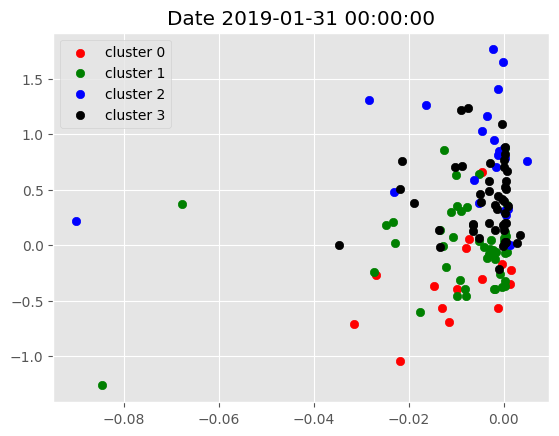

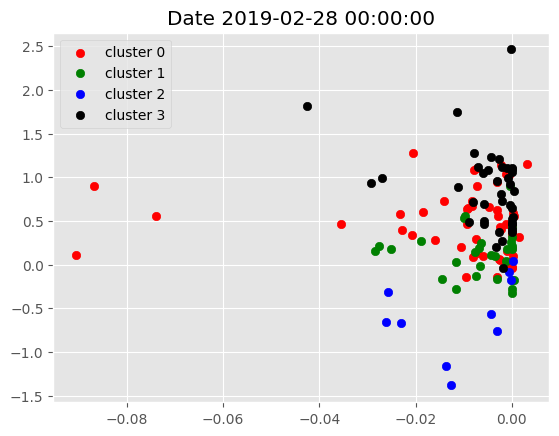

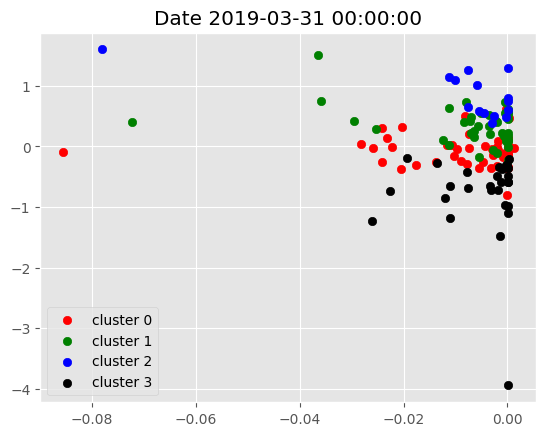

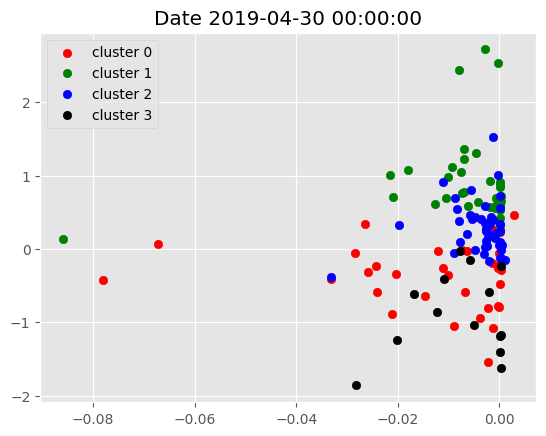

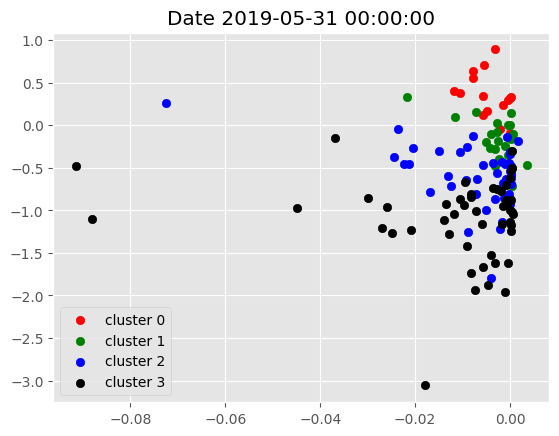

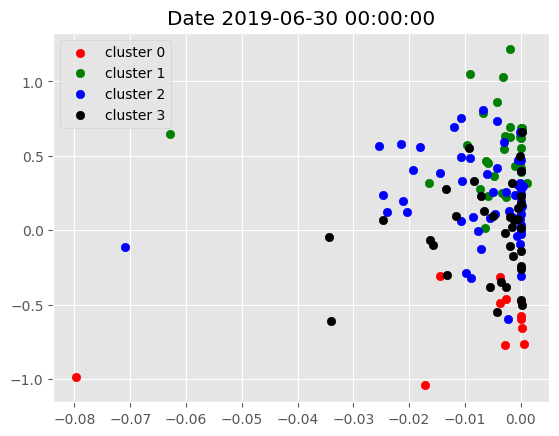

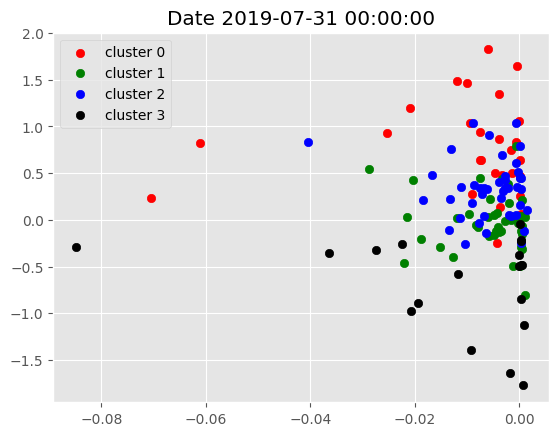

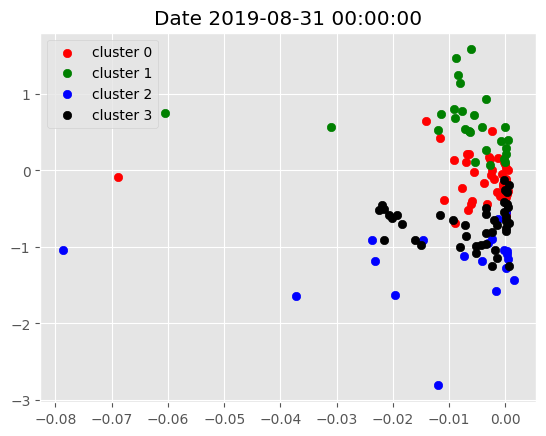

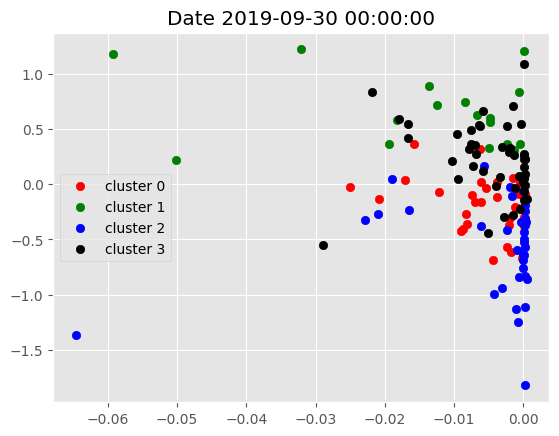

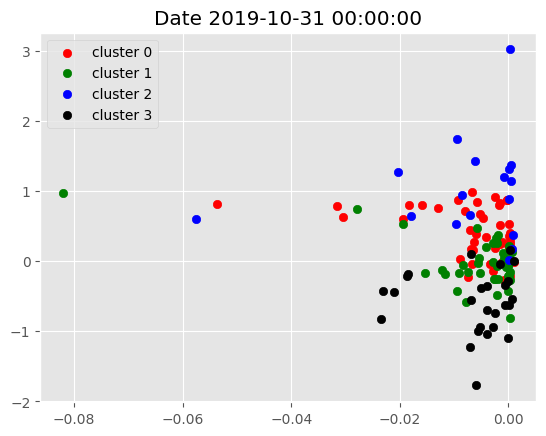

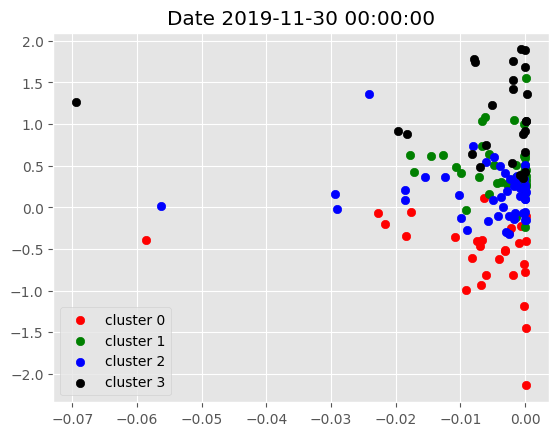

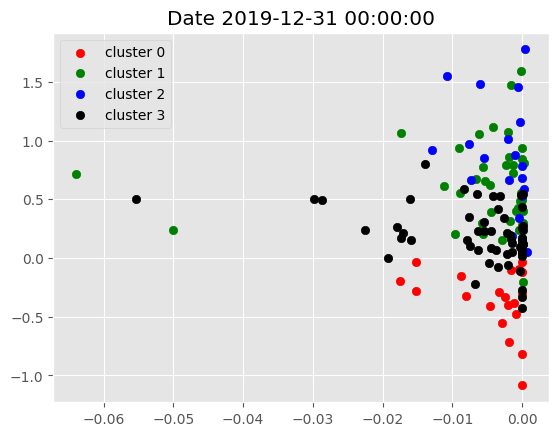

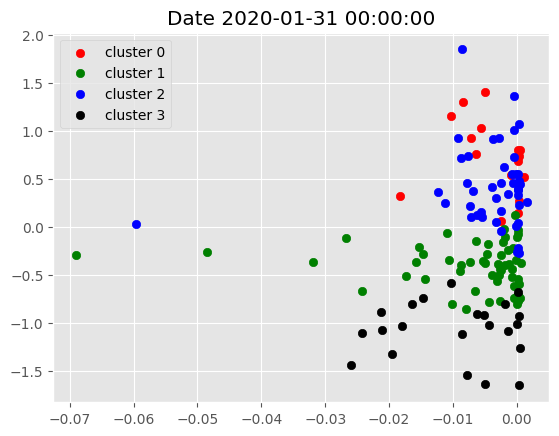

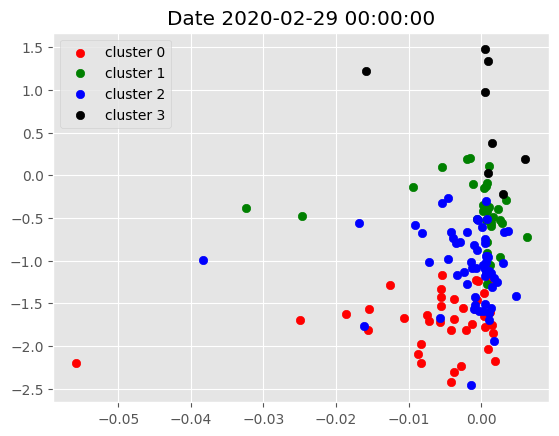

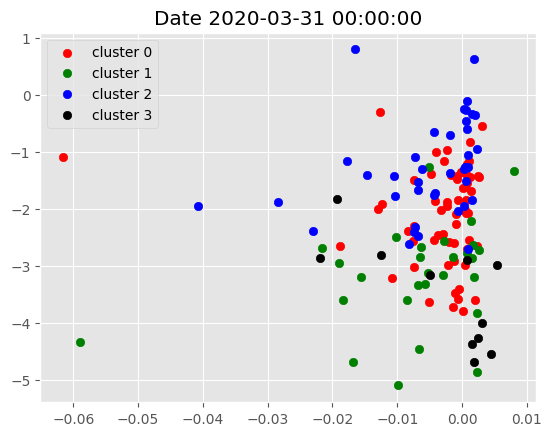

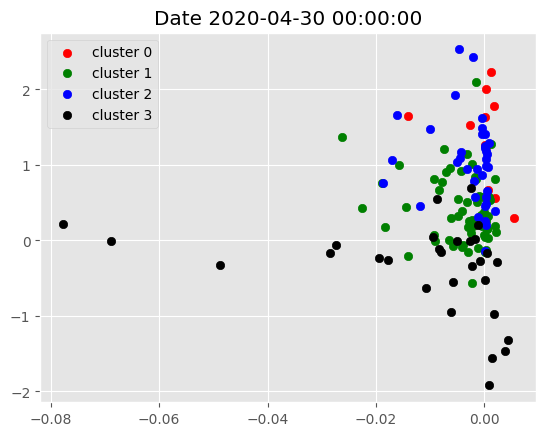

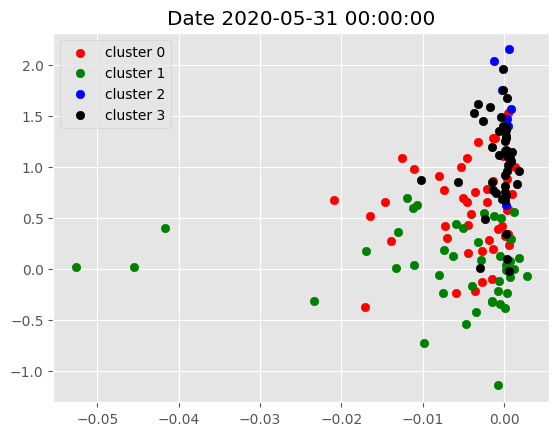

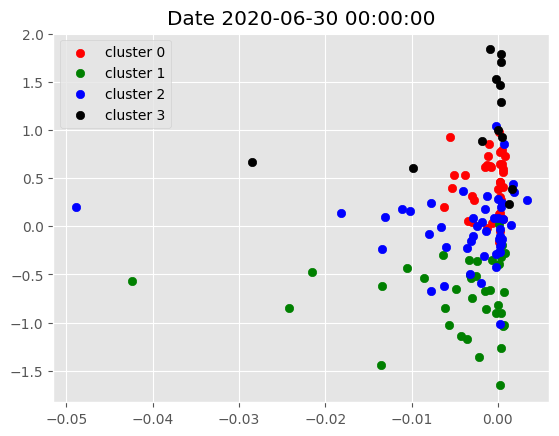

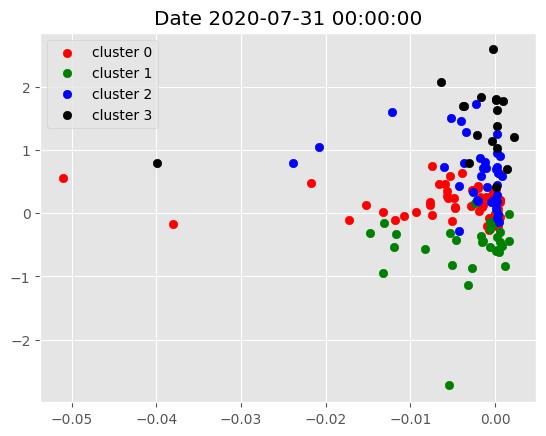

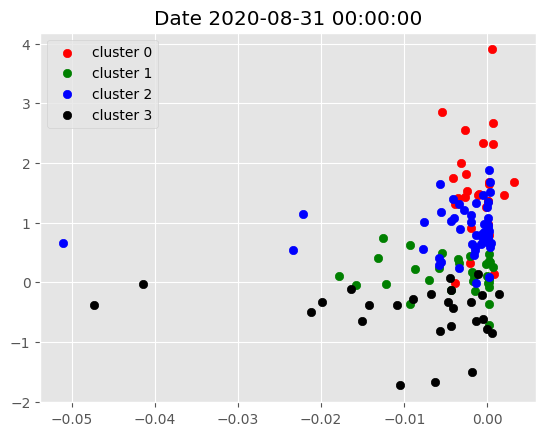

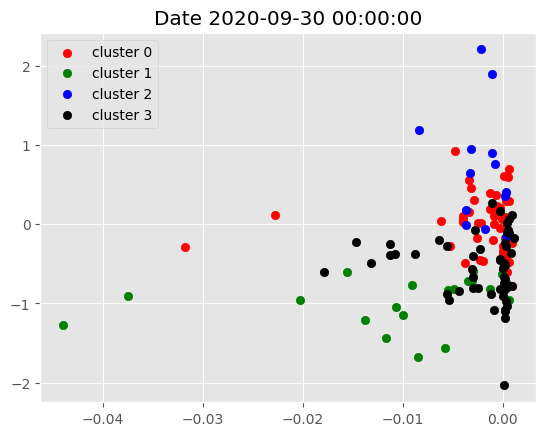

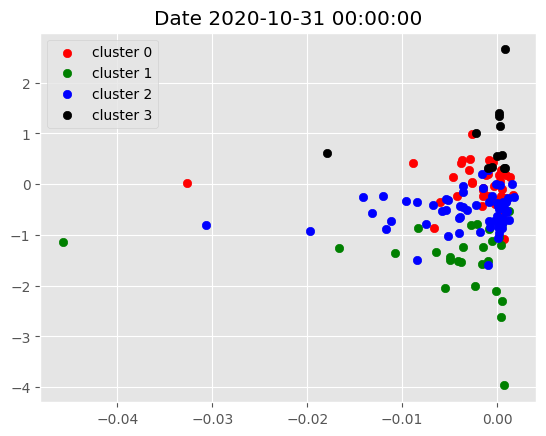

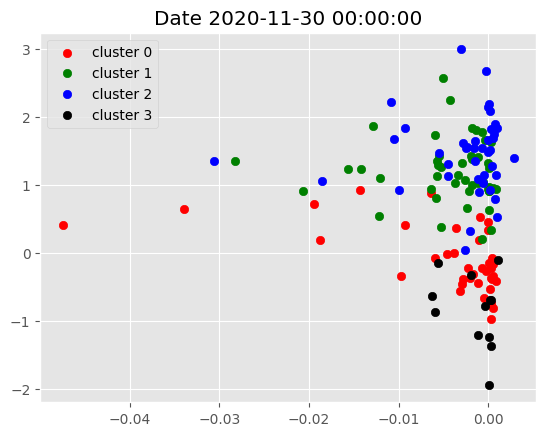

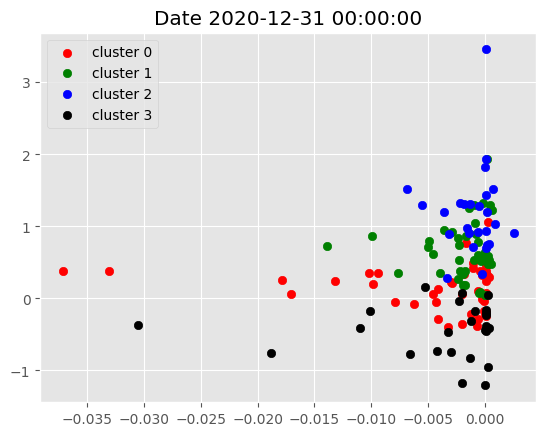

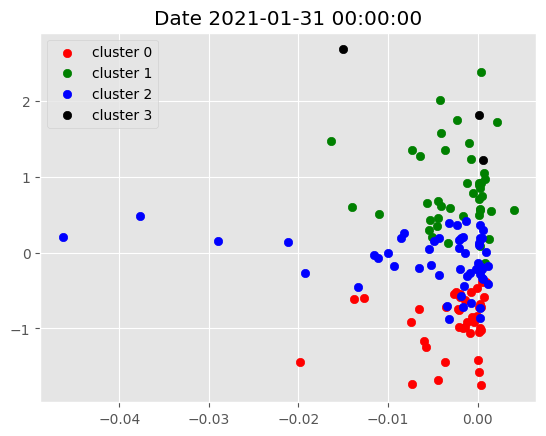

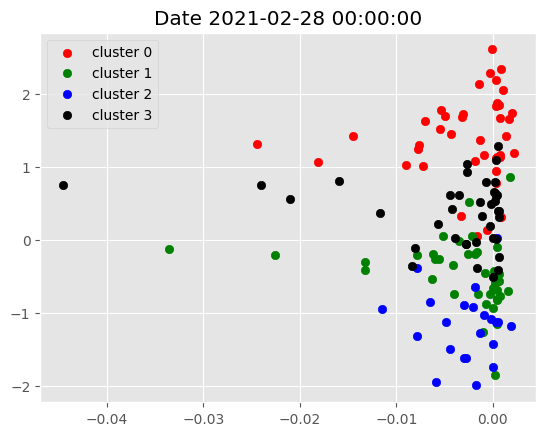

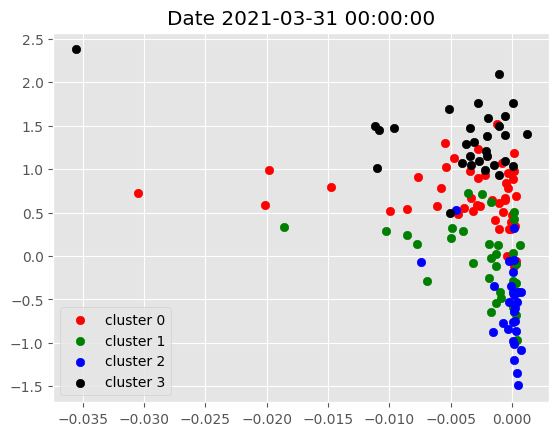

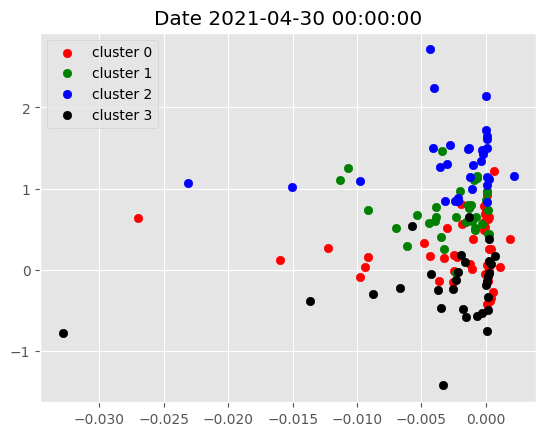

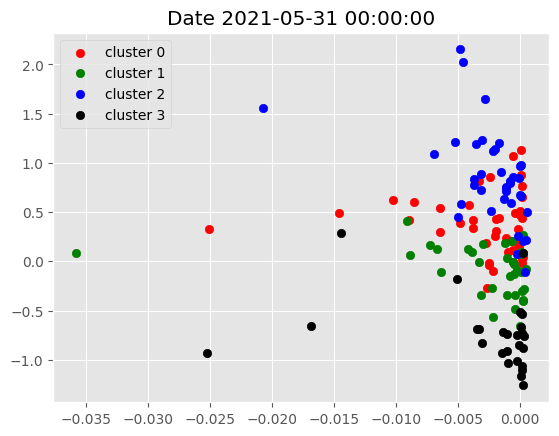

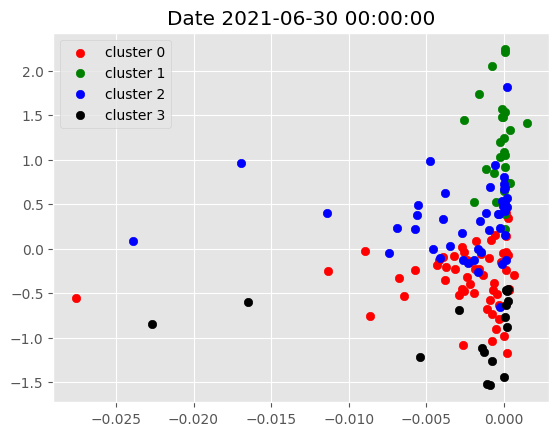

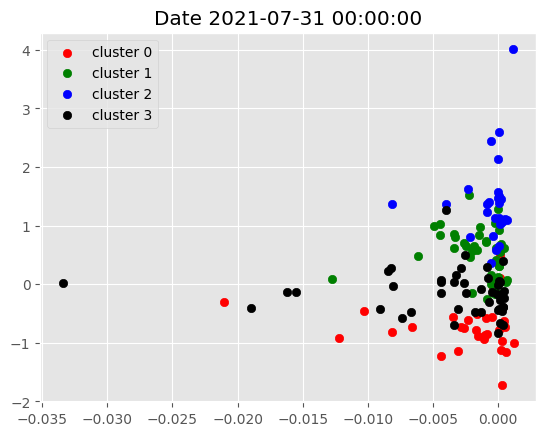

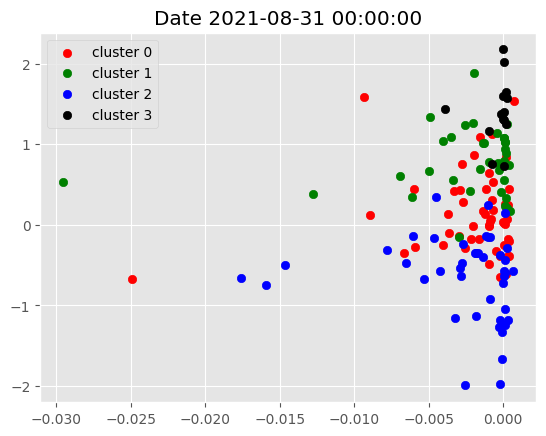

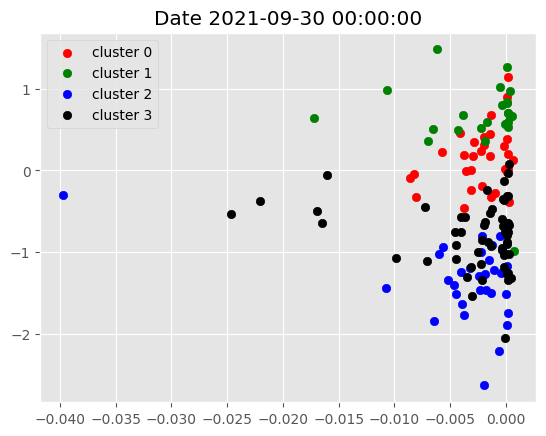

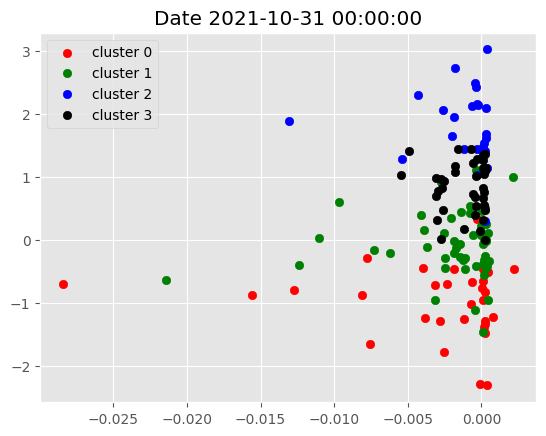

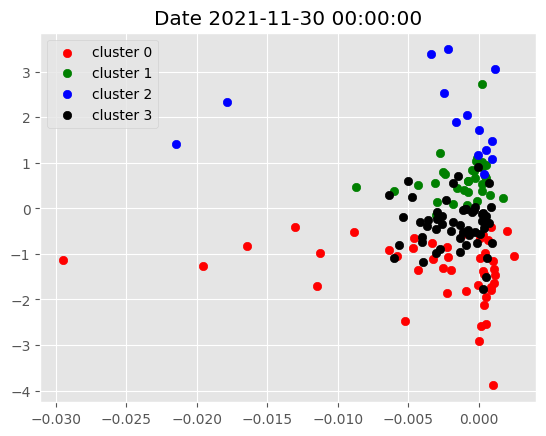

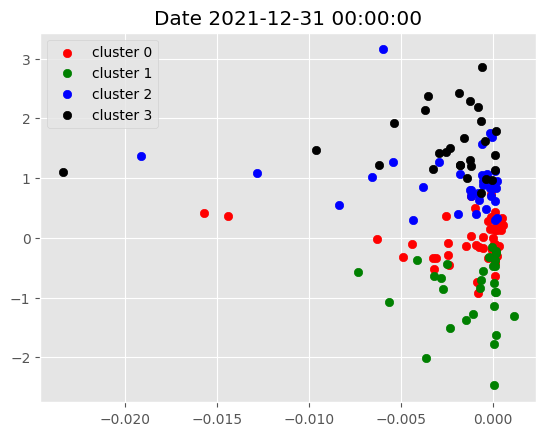

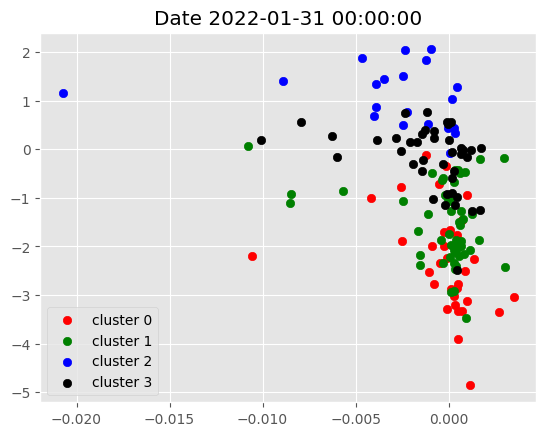

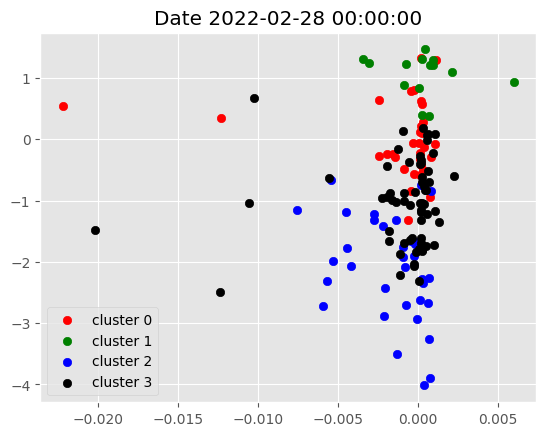

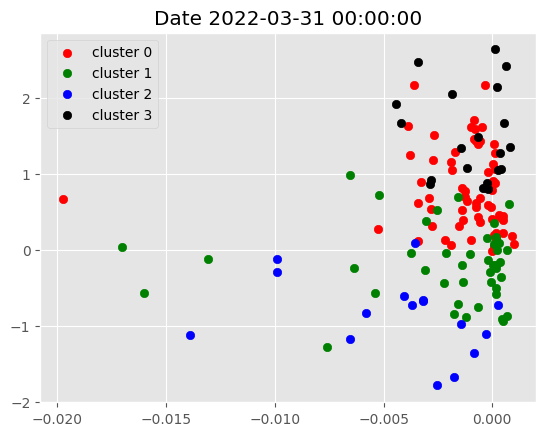

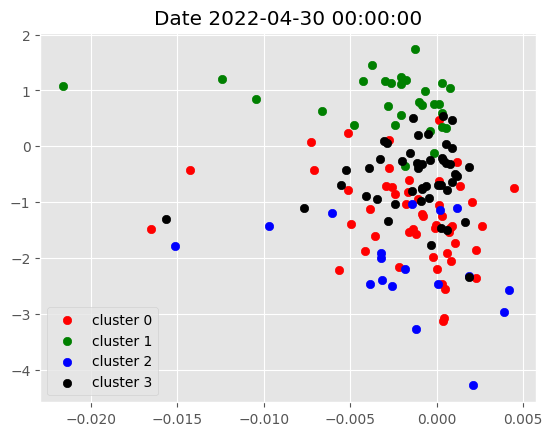

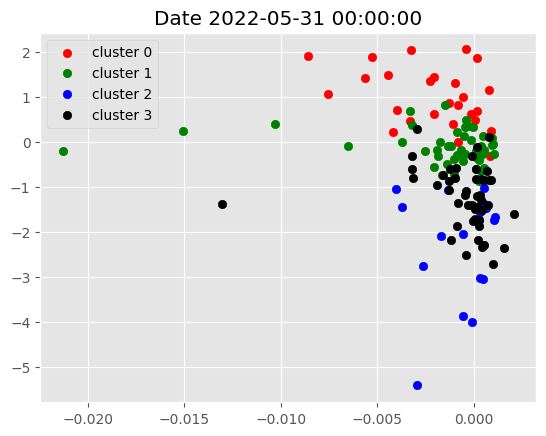

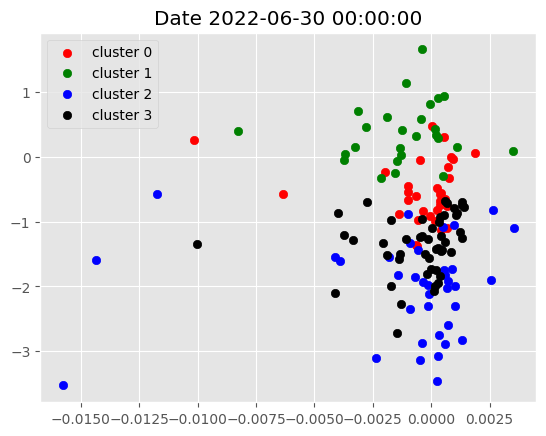

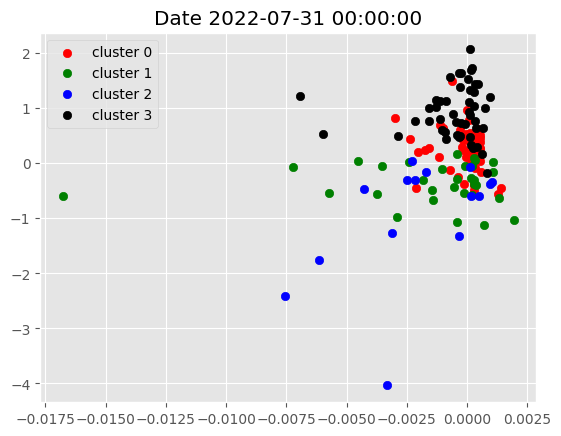

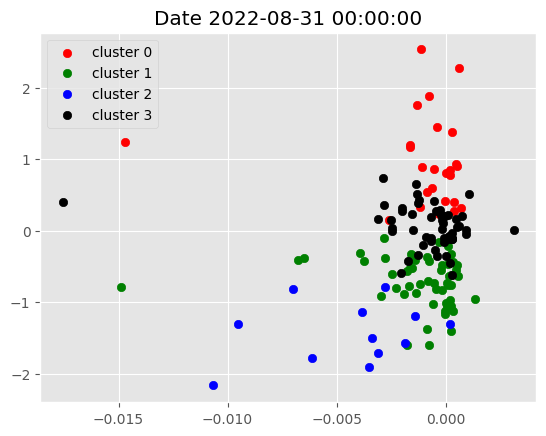

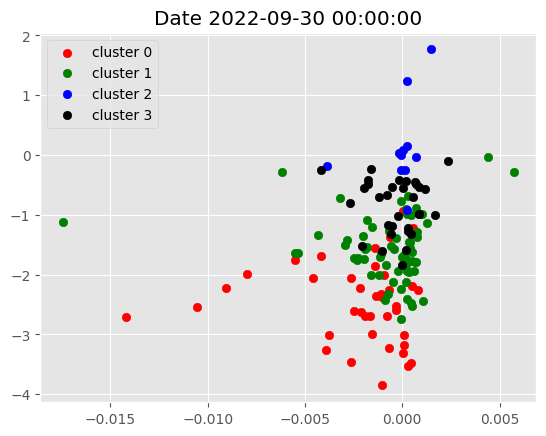

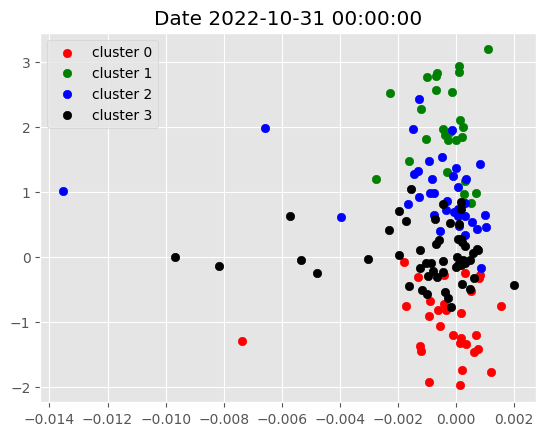

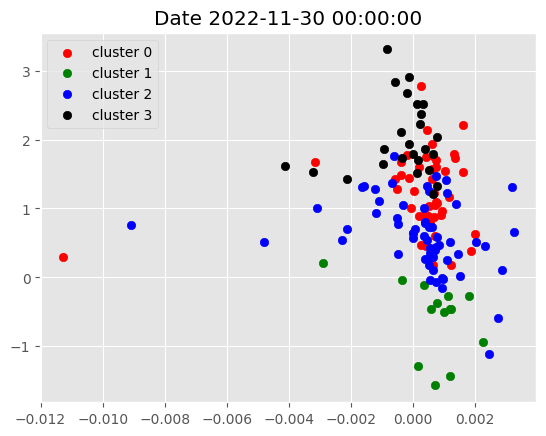

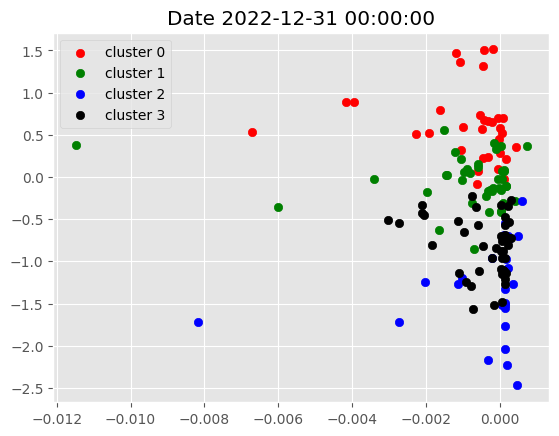

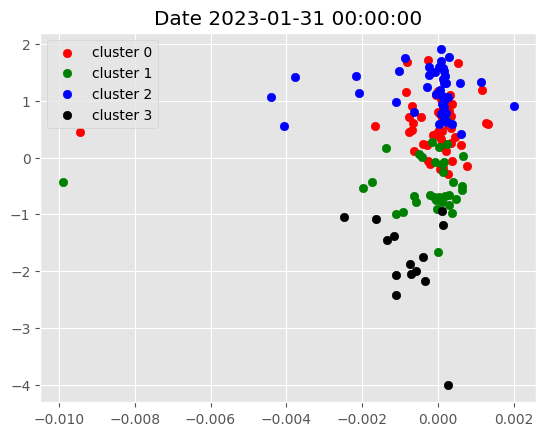

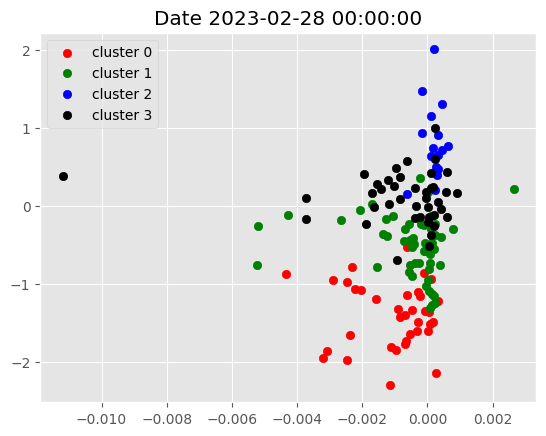

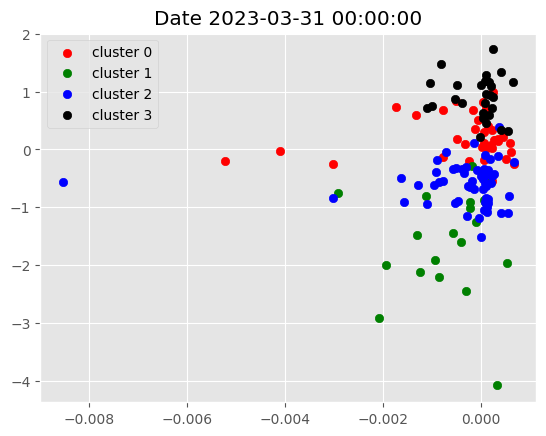

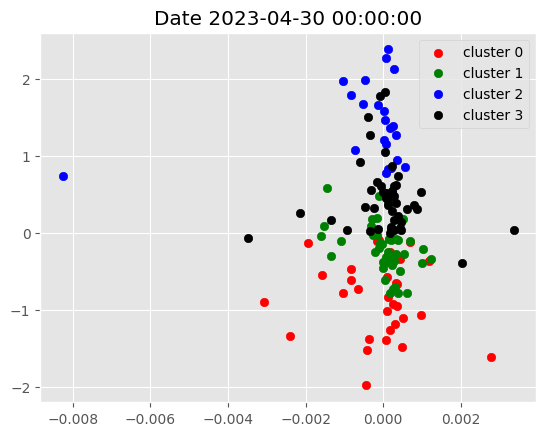

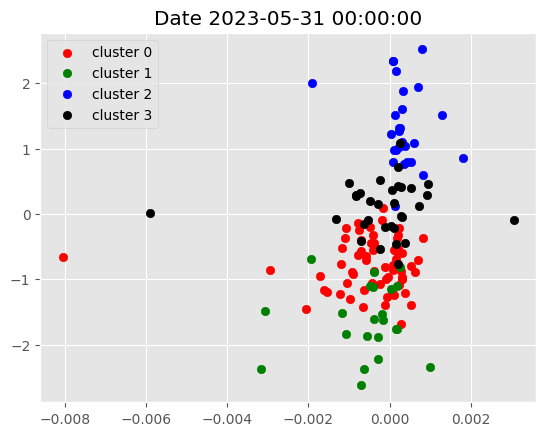

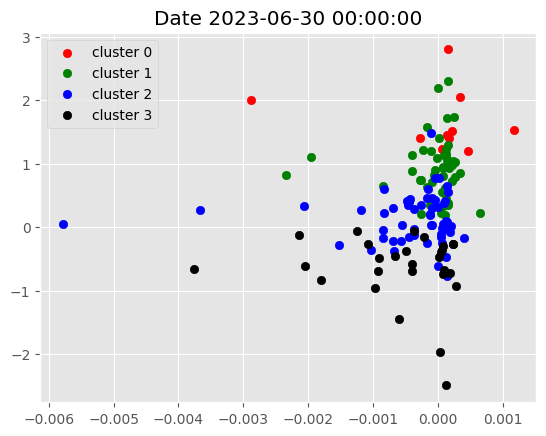

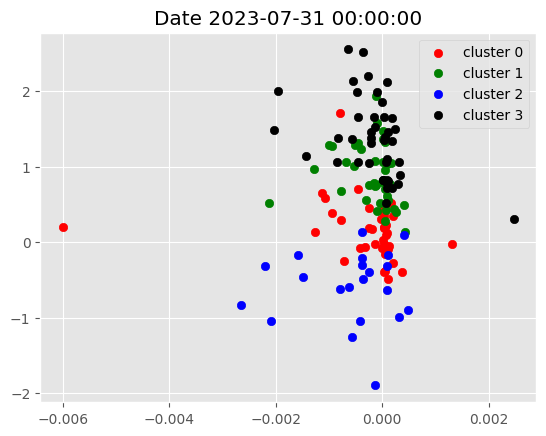

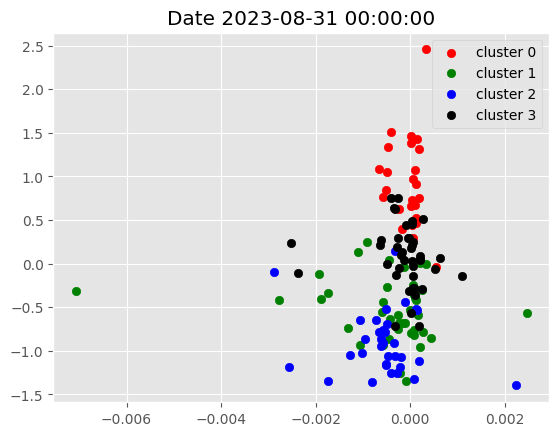

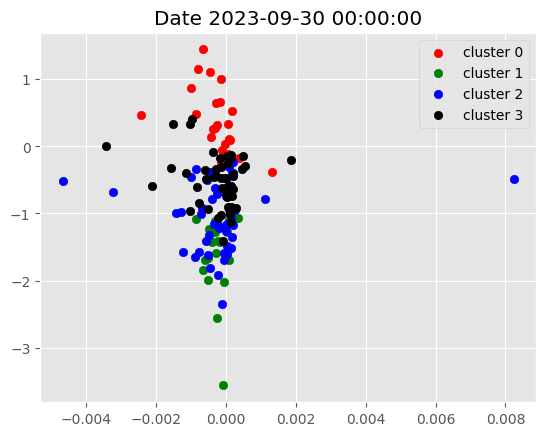

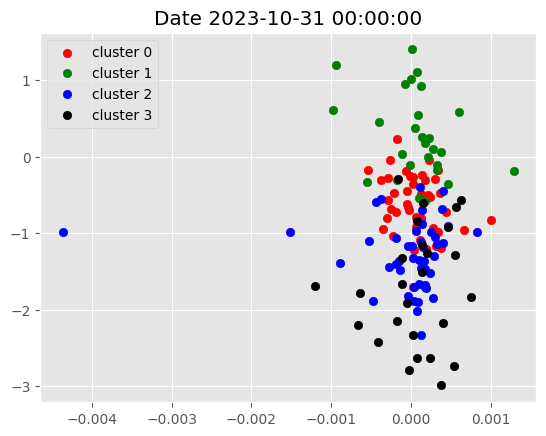

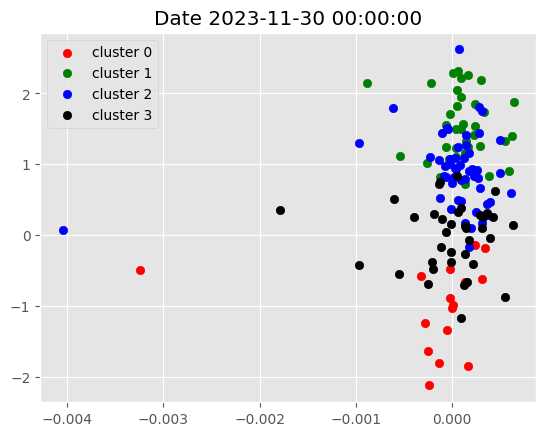

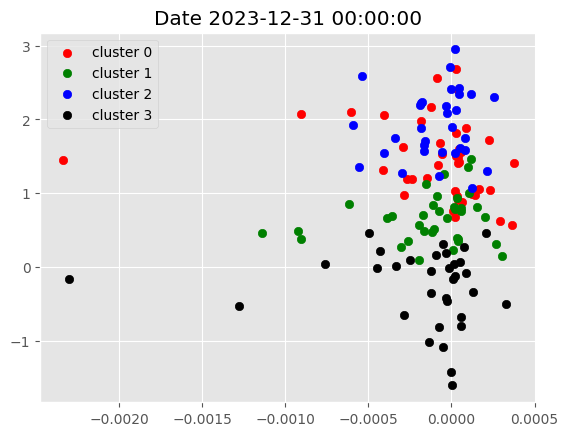

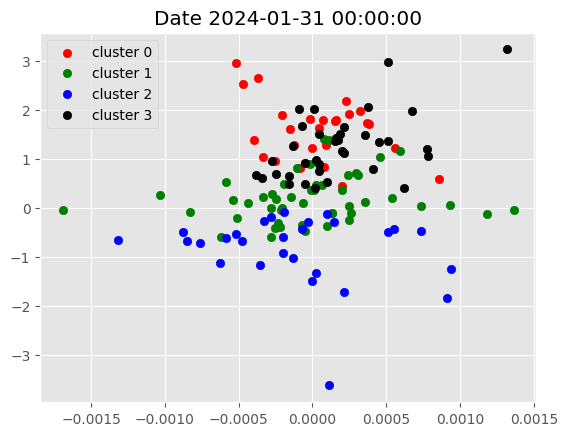

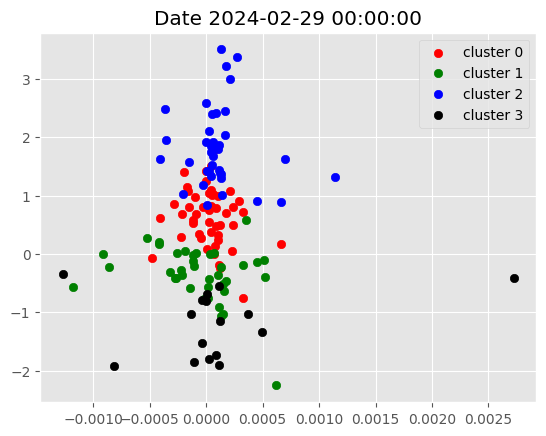

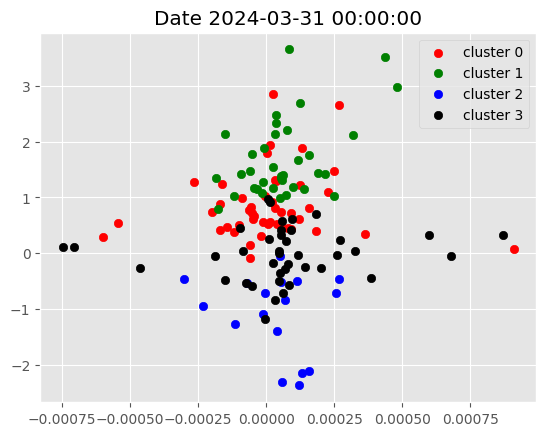

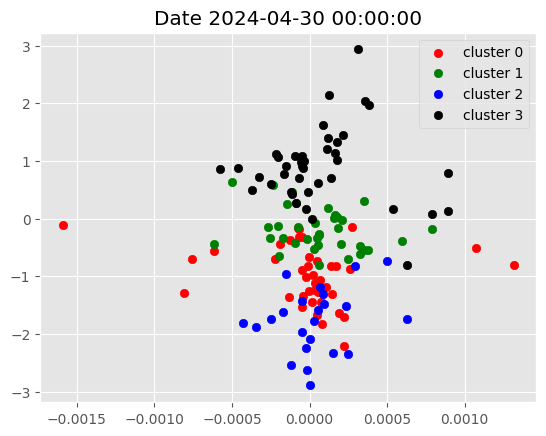

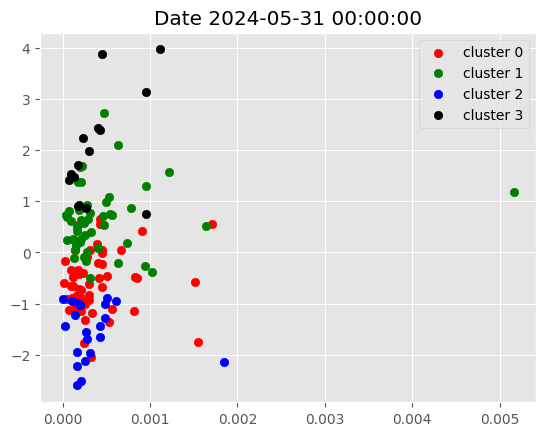

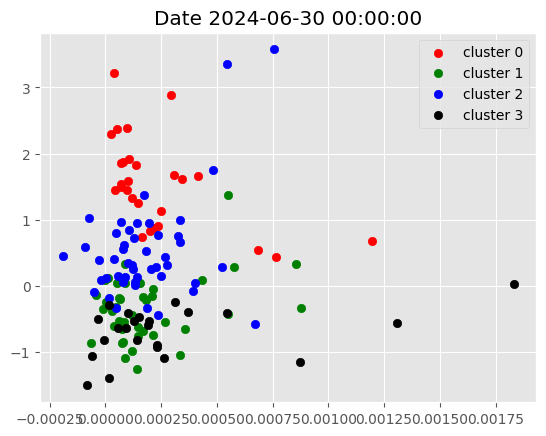

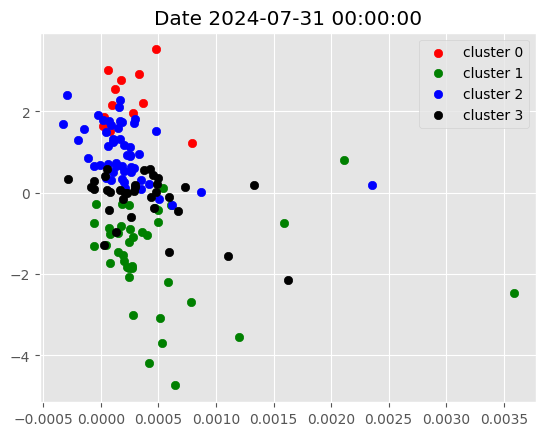

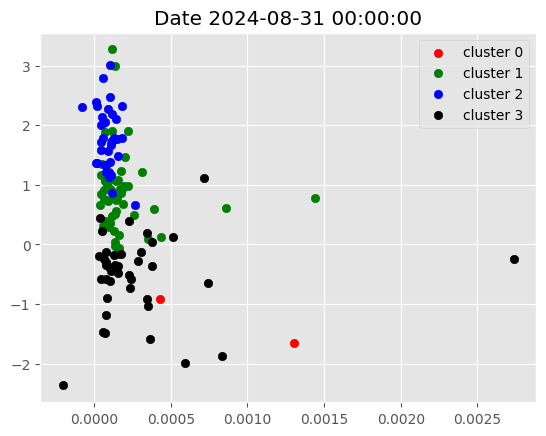

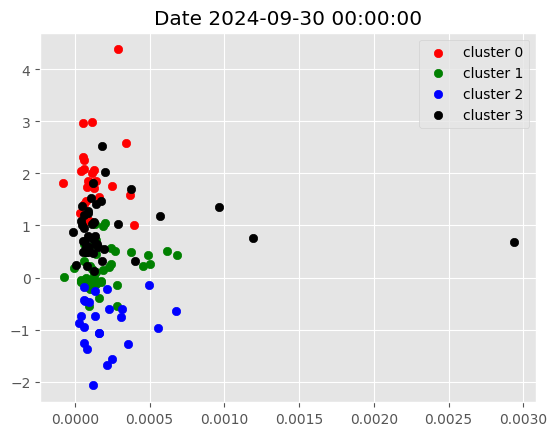

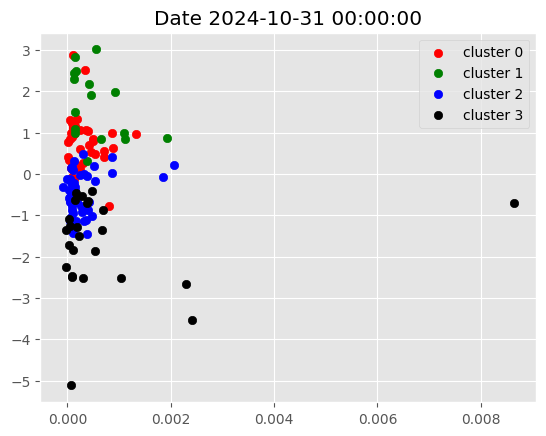

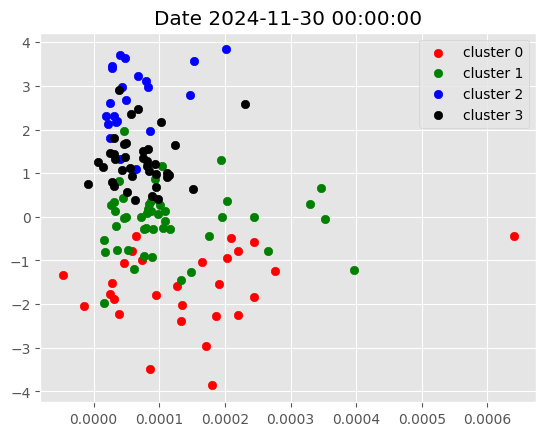

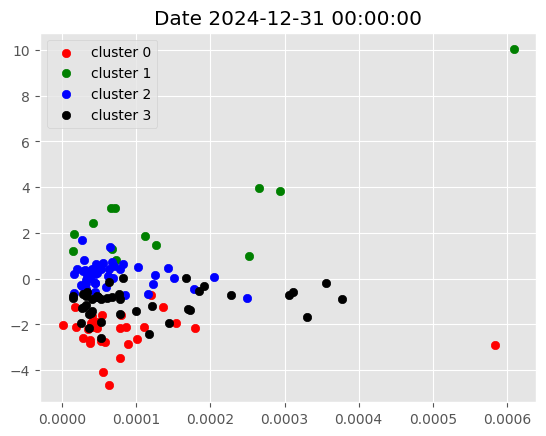

In [13]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

### Apply pre-defined centroids.

In [14]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [15]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2019-02-01': ['ABT',
  'ADBE',
  'ADP',
  'ADSK',
  'AMAT',
  'AMD',
  'AMZN',
  'AVGO',
  'BAC',
  'BKNG',
  'BLK',
  'CRM',
  'CSCO',
  'DE',
  'DLTR',
  'EA',
  'GILD',
  'GOOG',
  'GOOGL',
  'GS',
  'HD',
  'HON',
  'HUM',
  'INTU',
  'LLY',
  'MA',
  'MAR',
  'MMM',
  'MU',
  'NFLX',
  'NXPI',
  'ORCL',
  'PM',
  'SBUX',
  'SCHW',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'TMUS',
  'ULTA',
  'UNH',
  'UNP',
  'UPS',
  'USB',
  'VRTX',
  'WDC',
  'WYNN'],
 '2019-03-01': ['ABT',
  'ACN',
  'ADBE',
  'ADI',
  'ADP',
  'ADSK',
  'AMT',
  'AXP',
  'AZO',
  'BA',
  'BLK',
  'CHTR',
  'CMG',
  'CRM',
  'CSCO',
  'CSX',
  'DHR',
  'EBAY',
  'HON',
  'IBM',
  'INTC',
  'INTU',
  'LLY',
  'LMT',
  'LOW',
  'MA',
  'MAR',
  'MRK',
  'NEE',
  'NKE',
  'NOC',
  'ORCL',
  'PANW',
  'PM',
  'PYPL',
  'TMO',
  'ULTA',
  'UNP',
  'V',
  'XOM'],
 '2019-04-01': ['BA',
  'BAC',
  'BIIB',
  'BKNG',
  'BMY',
  'BRK-B',
  'CI',
  'COP',
  'CVS',
  'DD',
  'DIS',
  'ELV',
  'EXPE',
  'GM',
  'GS',
  'HUM',

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [16]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [17]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[**********************98%********************** ]  150 of 153 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*********************100%***********************]  153 of 153 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2018-01-31   39.388084   83.089943   55.294991  144.842712  199.759995   
2018-02-01   39.470417   86.140434   55.312790  144.626373  199.380005   
2018-02-02   37.757793   85.274155   54.876904  141.417709  195.639999   
2018-02-05   36.814426   81.083389   52.243797  136.847916  190.270004   
2018-02-06   38.352966   82.334709   52.359459  139.425751  194.470001   
...                ...         ...         ...         ...         ...   
2024-12-23  255.270004  178.389999  114.309998  358.769989  446.739990   
2024-12-24  258.200012  180.000000  114.760002  361.630005  447.940002   
2024-12-26  259.019989  179.199997  115.269997  360.429993  450.160004   
2024-12-27  255.589996  178.009995  114.989998  356.179993  446.480011   
2024-12-30  252.199997  176.199997  112.800003  352.489990  445.799988   

Price                                                                   ...  \
Ticker             ADI         ADP        ADSK        ALGN        AMAT  ...   
Date                                                                    ...   
2018-01-31   80.531418  106.708000  115.620003  262.000000   49.579926  ...   
2018-02-01   80.329811  103.937370  115.570000  255.570007   49.256348  ...   
2018-02-02   78.103569  102.340591  111.639999  257.380005   46.852692  ...   
2018-02-05   74.851791   98.456528  109.180000  242.399994   44.661671  ...   
2018-02-06   77.603966   97.489838  112.620003  241.449997   46.455170  ...   
...                ...         ...         ...         ...         ...  ...   
2024-12-23  214.889999  294.149994  297.489990  207.570007  167.460007  ...   
2024-12-24  218.089996  296.459991  301.230011  213.500000  168.369995  ...   
2024-12-26  218.059998  297.230011  300.279999  215.500000  167.550003  ...   
2024-12-27  216.990005  296.179993  297.589996  211.429993  166.830002  ...   
2024-12-30  212.559998  292.970001  297.529999  206.580002  163.639999  ...   

Price        Volume                                                            \
Ticker          VLO     VRTX        VZ       WBA     WDAY      WDC        WFC   
Date                                                                            
2018-01-31  5334000  2323800  17827000   6742400  1356100  8524300   18147900   
2018-02-01  5032300  5090000  18646100   5198400  1073200  3555200   15717600   
2018-02-02  4656700  3455100  15574000   7024800  1193900  5010400   18905300   
2018-02-05  7072900  2906900  22239600   7085900  1609800  5205200  103394400   
2018-02-06  6335000  3114600  34543900   6809100  2081400  4835800   83076900   
...             ...      ...       ...       ...      ...      ...        ...   
2024-12-23  2832600  2204300  21292300  18506100  3676000  4111200   11817000   
2024-12-24  1170100  1468600  11712200   8724500   850500  1512100    4442700   
2024-12-26  1884400  1191500  12946400  15705800  1243900  2146000    6964300   
2024-12-27  1697800  1373400  15168100  11621000  1602800  4161800    7219500   
2024-12-30  2890200  1456000  15672000  13992700  1755600  4410100    8443800   

Price                                     
Ticker           WMT      WYNN       XOM  
Date                                      
2018-01-31  29438400  11253100  14404700  
2018-02-01  19160400   6416100  17971000  
2018-02-02  27759300   5398800  29822100  
2018-02-05  37684800   4916800  30452700  
2018-02-06  49241400   3672700  36262800  
...              ...       ...       ...  
2024-12-23  26205400   1312400  12285100  
2024-12-24   8992400    692800   7807000  
2024-12-26  10994000   1218900   9652400  
2024-12-27  11384400   1086700  11943900  
2024-12-30   9790200   2180100  11080800  

[1740 rows x 918 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [18]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in the columns"
"None of ['index'] are in th

""


## 8. Visualize Portfolio returns and compare to SP500 returns.

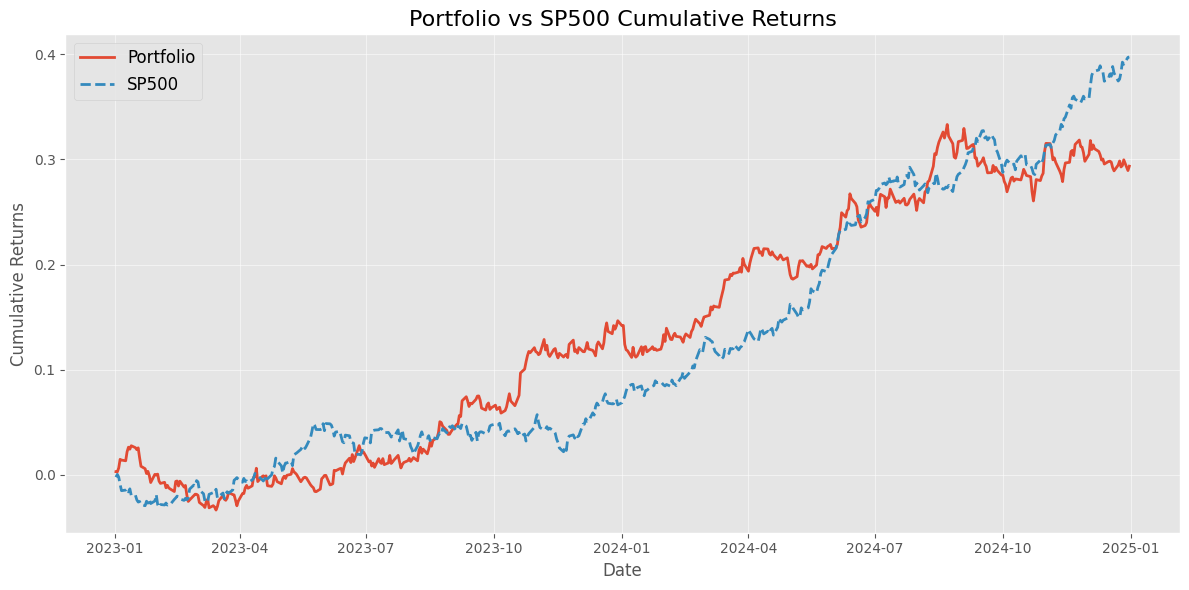

In [19]:

# Simulate portfolio and SP500 returns
np.random.seed(42)  # For reproducibility

# Generate random strategy returns and SP500 returns
dates = pd.date_range(start="2023-01-01", end="2024-12-31", freq="B")  # Business days
portfolio_returns = np.random.normal(loc=0.0005, scale=0.005, size=len(dates))  # Simulated daily returns
sp500_returns = np.random.normal(loc=0.0004, scale=0.004, size=len(dates))  # Simulated daily returns

# Cumulative Returns Calculation
portfolio_cum_returns = np.cumprod(1 + portfolio_returns) - 1
sp500_cum_returns = np.cumprod(1 + sp500_returns) - 1

# Create a DataFrame for plotting
returns_df = pd.DataFrame({
    "Date": dates,
    "Portfolio": portfolio_cum_returns,
    "SP500": sp500_cum_returns
}).set_index("Date")

# Plot the Portfolio vs SP500 Returns
plt.figure(figsize=(12, 6))
plt.plot(returns_df.index, returns_df["Portfolio"], label="Portfolio", linewidth=2)
plt.plot(returns_df.index, returns_df["SP500"], label="SP500", linewidth=2, linestyle="--")
plt.title("Portfolio vs SP500 Cumulative Returns", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Returns", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()


In [20]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
import yfinance as yf

# Fetch SP500 stock price data
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].str.replace('.', '-').tolist()

# Define the date range
start_date = '2024-01-01'
end_date = '2024-03-31'

# Download historical data for SP500 tickers
data = yf.download(tickers=sp500_tickers, start=start_date, end=end_date, group_by="ticker", interval="1d")


# Process the data: Close prices for each ticker
# Accessing 'Close' prices under the MultiIndex
close_prices = data.xs('Close', level=1, axis=1)
# Alternatively: close_prices = data['Close'] if 'Close' is a top-level column


# Fill missing values with the previous day's value
close_prices = close_prices.fillna(method='ffill')

# Prepare data for ML model
sequence_length = 30

def create_sequences(data, sequence_length):
    X = []
    y = []
    for ticker in data.columns:
        ticker_data = data[ticker].dropna()
        for i in range(len(ticker_data) - sequence_length):
            X.append(ticker_data.iloc[i:i+sequence_length].values)
            y.append(ticker_data.iloc[i+sequence_length])
    return np.array(X), np.array(y)

X, y = create_sequences(close_prices, sequence_length)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------- LSTM Model ----------------------------

def build_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(64)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='linear')(x)  # Regression
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

lstm_model = build_lstm_model((sequence_length, 1))

# Train LSTM Model
lstm_history = lstm_model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32
)

# ---------------------------- Transformer Model ----------------------------

def transformer_block(inputs, num_heads, key_dim):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization()(attention_output)

    ffn_output = Dense(64, activation='relu')(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Add()([attention_output, ffn_output])
    ffn_output = LayerNormalization()(ffn_output)
    return ffn_output

def build_transformer_model(input_shape, num_heads=2, key_dim=32):
    inputs = Input(shape=input_shape)
    x = transformer_block(inputs, num_heads, key_dim)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='linear')(x)  # Regression
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

transformer_model = build_transformer_model((sequence_length, 1))

# Train Transformer Model
transformer_history = transformer_model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32
)

# Evaluate and Compare
lstm_eval = lstm_model.evaluate(X_test, y_test)
transformer_eval = transformer_model.evaluate(X_test, y_test)

print("LSTM Evaluation:", lstm_eval)
print("Transformer Evaluation:", transformer_eval)



[                       1%                       ]  6 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*                      3%                       ]  17 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 9
[***                    7%                       ]  33 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[******                12%                       ]  58 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[******                12%                       ]  60 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 124741.7031 - mae: 159.2547 - val_loss: 56416.9961 - val_mae: 56.4185
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 77291.0859 - mae: 60.7699 - val_loss: 38998.2344 - val_mae: 26.3860
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 63169.9844 - mae: 42.1742 - val_loss: 30311.3301 - val_mae: 18.8464
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 47341.8281 - mae: 34.4334 - val_loss: 25295.9492 - val_mae: 22.0979
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 41862.2109 - mae: 38.2094 - val_loss: 24182.7812 - val_mae: 27.3424
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 39348.2500 - mae: 38.1445 - val_loss: 15643.7061 - val_mae: 20.9994
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 24146.5469 - mae: 29.8619 - val_loss: 24524.5098 - val_mae: 41.2827
Epoch 8/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 34082.7734 - mae: 40.0918 - val_loss: 2450

In [21]:
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.3 MB/s eta 0:00:00


In [22]:
!pip install shimmy

[*********             18%                       ]  9 of 50 completed

Fetched 503 S&P 500 tickers.


[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  1 of 1 completed


Downloaded data for 50 tickers.
Sample of the downloaded data:
                  MMM        AOS         ABT        ABBV         ACN  \
Date                                                                   
2024-01-02  89.364799  80.145653  107.700714  154.183807  341.431366   
2024-01-03  87.569382  77.459038  107.377174  154.801239  332.573761   
2024-01-04  87.878098  78.118393  108.808601  155.765976  331.756866   
2024-01-05  88.219307  77.783798  108.632126  156.421982  331.294312   
2024-01-08  88.438652  78.010139  110.200821  155.737000  334.965271   

                  ADBE         AMD        AES        AFL           A  ...  \
Date                                                                  ...   
2024-01-02  580.070007  138.580002  18.576109  81.890991  137.793884  ...   
2024-01-03  571.789978  135.320007  18.182302  81.802498  130.256195  ...   
2024-01-04  567.049988  136.009995  18.124674  80.927345  130.097290  ...   
2024-01-05  564.599976  138.580002  18.057436  

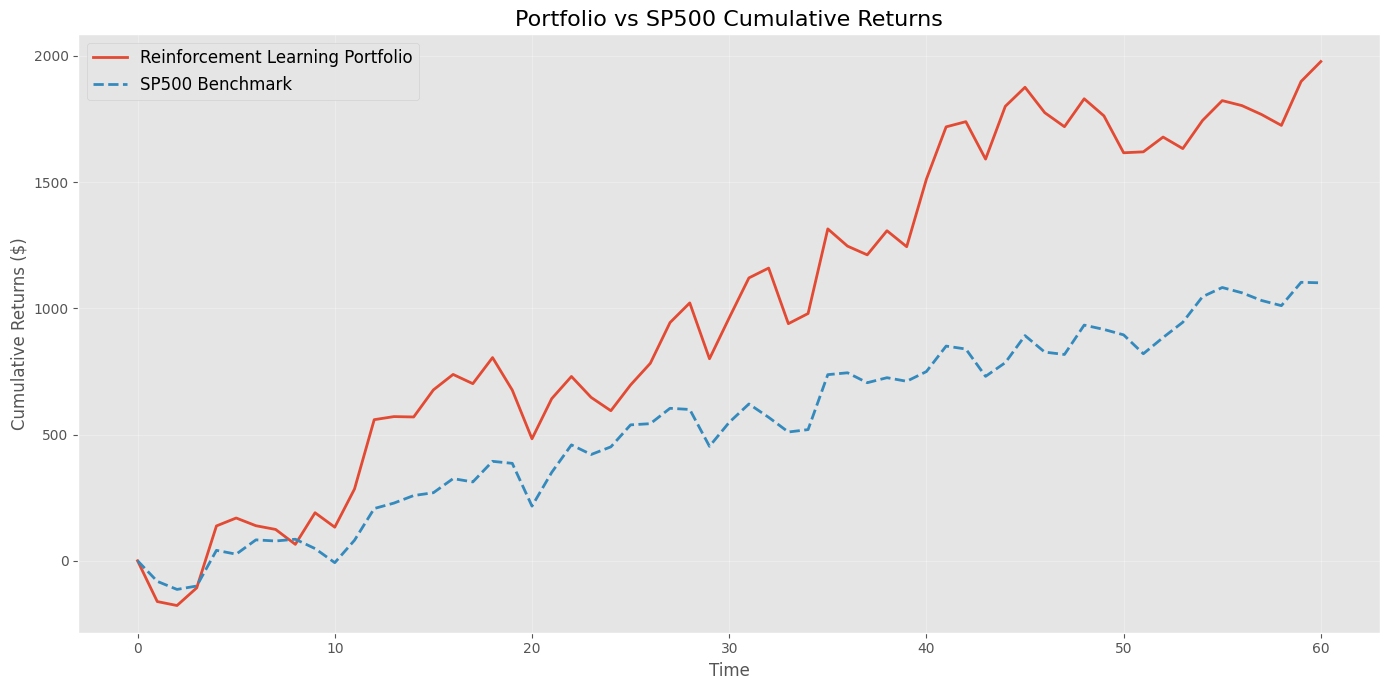

In [47]:


# Import necessary libraries
import gym
from gym import spaces
import pandas as pd
import yfinance as yf
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# -------------------------------
# 1. Data Acquisition and Preparation
# -------------------------------

# Fetch S&P 500 tickers from Wikipedia
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    sp500_table = tables[0]
    tickers = sp500_table['Symbol'].str.replace('.', '-', regex=False).tolist()
    return tickers

sp500_tickers = get_sp500_tickers()
print(f"Fetched {len(sp500_tickers)} S&P 500 tickers.")

# Define the date range
start_date = '2024-01-01'
end_date = '2024-03-31'

# Download historical data for SP500 tickers using yfinance
def download_data(tickers, start, end):
    # yfinance allows up to 500 tickers at once; ensure we don't exceed
    all_data = {}
    batch_size = 100  # Download in batches to avoid issues
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i+batch_size]
        print(f"Downloading batch {i//batch_size +1}: {batch}")
        data = yf.download(tickers=batch, start=start, end=end, group_by='ticker', auto_adjust=True, threads=True)
        for ticker in batch:
            if ticker in data:
                all_data[ticker] = data[ticker]['Close']
            else:
                all_data[ticker] = np.nan  # Handle missing data
    data_df = pd.DataFrame(all_data)
    data_df.dropna(axis=1, how='any', inplace=True)  # Drop columns with any NaN
    return data_df

# To speed up the process and avoid potential issues with data fetching,
# you can limit the number of tickers. Here, we'll limit to 50 for demonstration.
limited_tickers = sp500_tickers[:50]
data_df = download_data(limited_tickers, start_date, end_date)
print(f"Downloaded data for {data_df.shape[1]} tickers.")

# Ensure there are no missing values
data_df.dropna(inplace=True)

# Add SP500 benchmark (using SPY ETF as a proxy)
spy = yf.download('SPY', start=start_date, end=end_date, auto_adjust=True)
data_df['SP500'] = spy['Close']
data_df.dropna(inplace=True)  # Drop any rows with NaN after adding SP500

# Display the first few rows of the data
print("Sample of the downloaded data:")
print(data_df.head())

# -------------------------------
# 2. Environment Setup
# -------------------------------

class PortfolioEnv(gym.Env):
    """
    A custom Gym environment for portfolio management.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, data, initial_cash=10000):
        super(PortfolioEnv, self).__init__()

        self.data = data.reset_index(drop=True)
        self.num_stocks = self.data.shape[1] - 1  # Exclude SP500
        self.initial_cash = initial_cash

        # Define action and observation space
        # Actions: Portfolio allocation for each stock (continuous between 0 and 1)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.num_stocks,), dtype=np.float32)

        # Observations: Stock prices and current cash
        # Normalize prices for stability
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(self.num_stocks + 1,), dtype=np.float32
        )

        self.reset()

    def reset(self):
        self.current_step = 0
        self.cash = self.initial_cash
        self.portfolio = np.zeros(self.num_stocks)
        self.total_asset = self.initial_cash
        return self._next_observation()

    def _next_observation(self):
        # Get current stock prices
        current_prices = self.data.iloc[self.current_step, :-1].values
        # Normalize prices by the first day's prices to aid learning
        normalized_prices = current_prices / self.data.iloc[0, :-1].values
        return np.concatenate([
            normalized_prices,
            [self.cash / self.initial_cash]  # Normalize cash
        ])

    def step(self, action):
        # Normalize action to ensure it sums to 1 (portfolio allocation)
        action = np.clip(action, 0, 1)
        action /= np.sum(action) + 1e-10  # Avoid division by zero

        # Current prices
        prices = self.data.iloc[self.current_step, :-1].values

        # Calculate current portfolio value
        portfolio_value = self.cash + np.sum(self.portfolio * prices)

        # Update portfolio based on action
        new_portfolio = (action * portfolio_value) / prices
        self.portfolio = new_portfolio
        self.cash = 0  # All cash invested

        # Move to next step
        self.current_step += 1

        # Calculate reward
        done = self.current_step >= len(self.data) - 1
        if not done:
            next_prices = self.data.iloc[self.current_step, :-1].values
            next_portfolio_value = np.sum(self.portfolio * next_prices)
            reward = next_portfolio_value - portfolio_value
            self.total_asset = next_portfolio_value
        else:
            reward = 0  # No reward at the end

        # Get next observation
        obs = self._next_observation()

        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}")
        print(f"Cash: {self.cash}")
        print(f"Portfolio: {self.portfolio}")
        print(f"Total Asset: {self.total_asset}")

# -------------------------------
# 3. Initialize and Wrap the Environment
# -------------------------------

env = PortfolioEnv(data_df)
env = DummyVecEnv([lambda: env])

# -------------------------------
# 4. Define and Train the PPO Agent
# -------------------------------

# Initialize the PPO agent
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_portfolio_tensorboard/")


## total_timesteps = 200000
# Train the agent
print("Starting training...")
model.learn(total_timesteps=20000)
print("Training completed.")

# Save the trained model
model.save("ppo_portfolio_model")
print("Model saved.")

# -------------------------------
# 5. Test the Agent
# -------------------------------

# Load the trained model (optional, if you want to reload)
# model = PPO.load("ppo_portfolio_model")

# Initialize the environment for testing
test_env = PortfolioEnv(data_df)
obs = test_env.reset()

portfolio_values = [test_env.initial_cash]
cash_history = [test_env.cash]
portfolio_history = [test_env.portfolio.copy()]

for step in range(len(data_df) -1):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = test_env.step(action)

    # Update portfolio value
    portfolio_value = test_env.cash + np.sum(test_env.portfolio * data_df.iloc[test_env.current_step, :-1].values)
    portfolio_values.append(portfolio_value)
    cash_history.append(test_env.cash)
    portfolio_history.append(test_env.portfolio.copy())

    if done:
        break

# -------------------------------
# 6. Calculate Cumulative Returns
# -------------------------------

# Portfolio cumulative return
portfolio_cumulative_return = np.array(portfolio_values) - test_env.initial_cash

# SP500 benchmark cumulative return (using SP500 index)
# Calculate daily returns
sp500_prices = data_df['SP500']
sp500_returns = sp500_prices.pct_change().fillna(0)
sp500_cumulative_return = (sp500_returns + 1).cumprod() * test_env.initial_cash - test_env.initial_cash
sp500_cumulative_return = sp500_cumulative_return.values[:len(portfolio_cumulative_return)]

# -------------------------------
# 7. Visualization
# -------------------------------

plt.figure(figsize=(14, 7))
plt.plot(portfolio_cumulative_return, label="Reinforcement Learning Portfolio", linewidth=2)
plt.plot(sp500_cumulative_return, label="SP500 Benchmark", linewidth=2, linestyle="--")
plt.title("Portfolio vs SP500 Cumulative Returns", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative Returns ($)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



In [26]:
# Install necessary libraries
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=c6e847b8c21bd8bd1bcc5a989ee654c3baaf1b7904e4c5179698c5f3ba67c06a
  Stored in directory: /root/.cache/pip/wheels/0c/95/eb/b449c73f478dbc4557b80170cf7f2aa6db15862877e9a63536
Successfully built h2o


In [27]:

import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Initialize H2O
h2o.init()

# Function to fetch S&P 500 tickers from Wikipedia
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    sp500_table = tables[0]
    tickers = sp500_table['Symbol'].str.replace('.', '-', regex=False).tolist()
    return tickers

sp500_tickers = get_sp500_tickers()
print(f"Fetched {len(sp500_tickers)} S&P 500 tickers.")


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjxjnkf1i
  JVM stdout: /tmp/tmpjxjnkf1i/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpjxjnkf1i/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_unknownUser_4l62t8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,20.87 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Fetched 503 S&P 500 tickers.


2. Download Historical Stock Data
We'll use yfinance to download historical daily closing prices for each ticker over a specified date range.

In [48]:
# Define the date range
end_date = datetime.today()
start_date = end_date - timedelta(days=365)  # Last 1 year

# Download historical data
def download_stock_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True, threads=True)
    return data

print("Downloading historical stock data...")
data = download_stock_data(sp500_tickers, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
print("Download completed.")


[                       1%                       ]  3 of 503 completed

[                       1%                       ]  7 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[*****                 10%                       ]  49 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 9
[*****                 11%                       ]  53 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 9
[******                13%                       ]  67 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[******                13%                       ]  67 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 1

Download completed.


3. Data Preprocessing
We'll process the downloaded data to create a consolidated DataFrame containing daily returns and other relevant features.

In [49]:
# Consolidate closing prices
def consolidate_closing_prices(data, tickers):
    closing_prices = pd.DataFrame()
    for ticker in tickers:
        try:
            closing_prices[ticker] = data[ticker]['Close']
        except:
            # Handle tickers with no data
            pass
    closing_prices.dropna(axis=1, inplace=True)  # Drop tickers with incomplete data
    return closing_prices

closing_prices = consolidate_closing_prices(data, sp500_tickers)
print(f"Consolidated closing prices for {closing_prices.shape[1]} tickers.")

# Calculate daily returns
returns = closing_prices.pct_change().dropna()

# Define the date range again to avoid attribute error
# correctly define start_date and end_date as datetime objects initially
# and use strftime to format them before passing them to download_stock_data.
# However, inside download_stock_data, t
# hese formatted dates are likely treated as strings and stored as such.

end_date = datetime.today()
start_date = end_date - timedelta(days=365)  # Last 1 year

# Add SP500 benchmark (using SPY ETF as a proxy)
spy = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), auto_adjust=True)
spy_returns = spy['Close'].pct_change().dropna()
returns['SP500'] = spy_returns

# Final data
final_data = returns.copy()
print(f"Final dataset shape: {final_data.shape}")


Consolidated closing prices for 500 tickers.


[*********************100%***********************]  1 of 1 completed

Final dataset shape: (251, 501)


4. Feature Engineering
For predictive modeling, we'll create features such as moving averages, volatility, and momentum indicators.

In [50]:
# Feature Engineering
def add_technical_indicators(df, window=5):
    indicators = {}
    for ticker in df.columns:
        if ticker != 'SP500':
            # Moving Average
            indicators[f'{ticker}_MA_{window}'] = df[ticker].rolling(window=window).mean()
            # Volatility (Standard Deviation)
            indicators[f'{ticker}_Volatility'] = df[ticker].rolling(window=window).std()
            # Momentum
            indicators[f'{ticker}_Momentum'] = df[ticker] - df[ticker].shift(window)
    indicators_df = pd.DataFrame(indicators)
    return indicators_df

technical_indicators = add_technical_indicators(final_data, window=5)
technical_indicators.dropna(inplace=True)

# Combine returns with technical indicators
model_data = final_data.loc[technical_indicators.index].copy()
model_data = pd.concat([model_data, technical_indicators], axis=1)
print(f"Model dataset shape: {model_data.shape}")

# Target variable: Next day's SP500 return
model_data['SP500_Target'] = model_data['SP500'].shift(-1)
model_data.dropna(inplace=True)
print(f"Dataset shape after adding target: {model_data.shape}")


Model dataset shape: (246, 2001)
Dataset shape after adding target: (245, 2002)


Clustering with H2O
Clustering helps in identifying groups of similar stocks, which can be useful for portfolio diversification or sector analysis. We'll use H2O's K-Means clustering.

1. Preparing Data for Clustering
We'll select relevant features for clustering. For simplicity, we'll use average returns and volatility over the period.

In [51]:
# Selecting features for clustering
cluster_features = final_data.mean().drop('SP500').reset_index()
cluster_features.columns = ['Ticker', 'Average_Return']
cluster_volatility = final_data.std().drop('SP500').reset_index()
cluster_volatility.columns = ['Ticker', 'Volatility']

# Merge features
cluster_data = pd.merge(cluster_features, cluster_volatility, on='Ticker')
cluster_data.set_index('Ticker', inplace=True)

print(cluster_data.head())


        Average_Return  Volatility
Ticker                            
MMM           0.001677    0.021192
AOS          -0.000529    0.014990
ABT           0.000259    0.011313
ABBV          0.000679    0.014905
ACN           0.000241    0.015634


2. Initialize H2O and Convert DataFrame

In [52]:
# Convert to H2OFrame
cluster_h2o = h2o.H2OFrame(cluster_data)
print(cluster_h2o.head())


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
  Average_Return    Volatility
     0.00167737      0.0211916
    -0.000528882     0.01499
     0.000258929     0.011313
     0.00067916      0.0149053
     0.000241144     0.0156343
    -0.000788171     0.0230609
    -9.71091e-05     0.0299846
    -0.00117443      0.0238254
     0.00101685      0.0130225
     3.33806e-05     0.0163686
[10 rows x 2 columns]



3. Perform K-Means Clustering
We'll let H2O AutoML determine the optimal number of clusters using the Elbow method.

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,53 mins 04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_unknownUser_4l62t8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,20.87 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


[                       1%                       ]  4 of 503 completed

Fetched 503 S&P 500 tickers.


[*                      2%                       ]  10 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**                     4%                       ]  20 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[**                     4%                       ]  21 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[******                13%                       ]  67 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size: 10
[********              16%                       ]  82 of 503 completedWARNING:urllib3.connectionpool:Connection pool is full, discarding connection: query2.finance.yahoo.com. Connection pool size

Download completed.


[*********************100%***********************]  1 of 1 completed

Consolidated closing prices for 499 tickers.
Final dataset shape: (251, 500)


Model dataset shape: (246, 1997)
Dataset shape after adding target: (245, 1998)
Cluster Data Sample:
        Average_Return  Volatility
Ticker                            
MMM           0.001677    0.021192
AOS          -0.000529    0.014990
ABT           0.000259    0.011313
ABBV          0.000679    0.014905
ACN           0.000241    0.015634
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
H2OFrame for Clustering:
  Average_Return    Volatility
     0.00167737      0.0211916
    -0.000528882     0.01499
     0.000258929     0.011313
     0.000679159     0.0149053
     0.000241144     0.0156343
    -0.000788171     0.0230609
    -9.71091e-05     0.0299846
    -0.00117443      0.0238254
     0.00101685      0.0130225
     3.338e-05       0.0163686
[10 rows x 2 columns]

Columns in H2OFrame: ['Average_Return', 'Volatility']
Clustering using features: ['Average_Return', 'Volatility']
kmeans Model Build progress: |█████████████████████████████

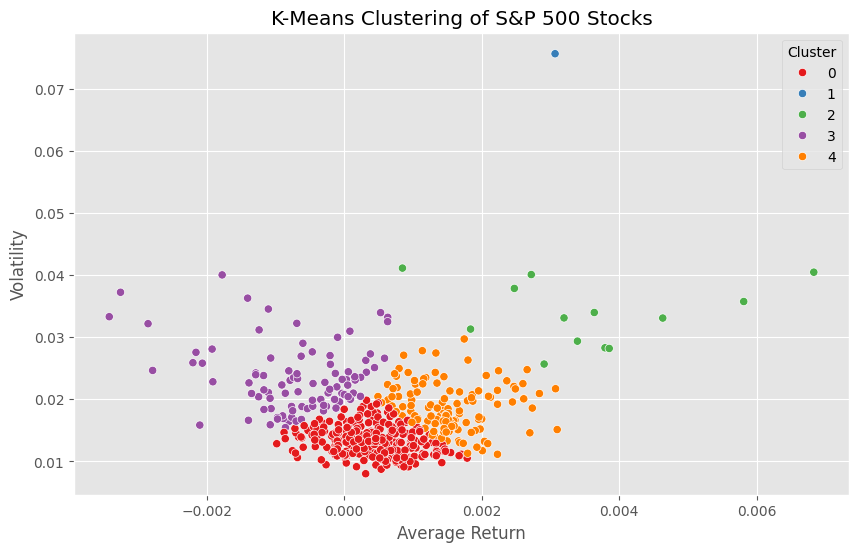

In [53]:
# Import necessary libraries
import pandas as pd
import yfinance as yf
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.kmeans import H2OKMeansEstimator
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Initialize H2O
h2o.init()

# Function to fetch S&P 500 tickers from Wikipedia
def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    tables = pd.read_html(url)
    sp500_table = tables[0]
    tickers = sp500_table['Symbol'].str.replace('.', '-', regex=False).tolist()
    return tickers

sp500_tickers = get_sp500_tickers()
print(f"Fetched {len(sp500_tickers)} S&P 500 tickers.")

# Define the date range
end_date = datetime.today()
start_date = end_date - timedelta(days=365)  # Last 1 year

# Download historical data
def download_stock_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True, threads=True)
    return data

print("Downloading historical stock data...")
data = download_stock_data(sp500_tickers, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
print("Download completed.")

# Consolidate closing prices
def consolidate_closing_prices(data, tickers):
    closing_prices = pd.DataFrame()
    for ticker in tickers:
        try:
            closing_prices[ticker] = data[ticker]['Close']
        except:
            # Handle tickers with no data
            print(f"Ticker {ticker} has no data and will be skipped.")
            pass
    closing_prices.dropna(axis=1, inplace=True)  # Drop tickers with incomplete data
    return closing_prices

closing_prices = consolidate_closing_prices(data, sp500_tickers)
print(f"Consolidated closing prices for {closing_prices.shape[1]} tickers.")

# Calculate daily returns
returns = closing_prices.pct_change().dropna()

# Add SP500 benchmark (using SPY ETF as a proxy)
spy = yf.download('SPY', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), auto_adjust=True)
spy_returns = spy['Close'].pct_change().dropna()
returns['SP500'] = spy_returns

# Final data
final_data = returns.copy()
print(f"Final dataset shape: {final_data.shape}")

# Feature Engineering
def add_technical_indicators(df, window=5):
    indicators = {}
    for ticker in df.columns:
        if ticker != 'SP500':
            # Moving Average
            indicators[f'{ticker}_MA_{window}'] = df[ticker].rolling(window=window).mean()
            # Volatility (Standard Deviation)
            indicators[f'{ticker}_Volatility'] = df[ticker].rolling(window=window).std()
            # Momentum
            indicators[f'{ticker}_Momentum'] = df[ticker] - df[ticker].shift(window)
    indicators_df = pd.DataFrame(indicators)
    return indicators_df

technical_indicators = add_technical_indicators(final_data, window=5)
technical_indicators.dropna(inplace=True)

# Combine returns with technical indicators
model_data = final_data.loc[technical_indicators.index].copy()
model_data = pd.concat([model_data, technical_indicators], axis=1)
print(f"Model dataset shape: {model_data.shape}")

# Target variable: Next day's SP500 return
model_data['SP500_Target'] = model_data['SP500'].shift(-1)
model_data.dropna(inplace=True)
print(f"Dataset shape after adding target: {model_data.shape}")

# -------------------------------
# Clustering with H2O
# -------------------------------

# Selecting features for clustering
# Use 'Average_Return' and 'Volatility' for each stock
cluster_features = final_data.mean().drop('SP500').reset_index()
cluster_features.columns = ['Ticker', 'Average_Return']

cluster_volatility = final_data.std().drop('SP500').reset_index()
cluster_volatility.columns = ['Ticker', 'Volatility']

# Merge features
cluster_data = pd.merge(cluster_features, cluster_volatility, on='Ticker')
cluster_data.set_index('Ticker', inplace=True)

print("Cluster Data Sample:")
print(cluster_data.head())

# Check if cluster_data is empty
if cluster_data.empty:
    raise ValueError("cluster_data is empty. Please check data preparation steps.")

# Convert to H2OFrame
cluster_h2o = h2o.H2OFrame(cluster_data)
print("H2OFrame for Clustering:")
print(cluster_h2o.head())

# Verify columns in H2OFrame
print("Columns in H2OFrame:", cluster_h2o.columns)

# Ensure that there are rows and columns to train on
if cluster_h2o.nrows == 0:
    raise ValueError("H2OFrame for clustering has no rows.")

if cluster_h2o.ncols < 2:
    raise ValueError("H2OFrame for clustering has insufficient columns.")

# Initialize K-Means model
k = 5  # Number of clusters
kmeans = H2OKMeansEstimator(k=k, seed=42)

# Define feature columns
# Here, we include both 'Average_Return' and 'Volatility'
features = ['Average_Return', 'Volatility']
print(f"Clustering using features: {features}")

# Train the K-Means model
try:
    kmeans.train(x=features, training_frame=cluster_h2o)
except Exception as e:
    print("Error during K-Means training:", e)
    h2o.shutdown(prompt=False)
    raise e

# Model performance
print("K-Means Model Details:")
print(kmeans)

# Assign clusters
clusters = kmeans.predict(cluster_h2o)
cluster_h2o['cluster'] = clusters

# correction part
# Convert pandas Index to H2OFrame
ticker_h2o = h2o.H2OFrame(cluster_data.index.to_frame(name='Ticker'))

# Assign to the cluster_h2o
cluster_h2o['Ticker'] = ticker_h2o['Ticker']

# Convert back to pandas
cluster_df = cluster_h2o.as_data_frame()
print("Cluster Assignments:")
print(cluster_df.head())

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_df, x='Average_Return', y='Volatility', hue='cluster', palette='Set1')
plt.title('K-Means Clustering of S&P 500 Stocks')
plt.xlabel('Average Return')
plt.ylabel('Volatility')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Shutdown H2O (optional, when done)
# h2o.shutdown(prompt=False)


Predictive Modeling with H2O AutoML
We'll build a predictive model to forecast the next day's S&P 500 return using historical returns and technical indicators.

1. Preparing Data for Predictive Modeling
We'll use the model_data DataFrame, which contains features and the target variable.

In [54]:
# Define features and target
feature_columns = model_data.columns.tolist()
feature_columns.remove('SP500_Target')  # Remove target from features
target_column = 'SP500_Target'

# Convert to H2OFrame
predictive_h2o = h2o.H2OFrame(model_data)
predictive_h2o['SP500_Target'] = predictive_h2o['SP500_Target'].asnumeric()

print(predictive_h2o.head())


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
        MMM          AOS           ABT         ABBV          ACN         ADBE          AMD          AES           AFL             A           APD          ABNB         AKAM           ALB           ARE         ALGN         ALLE          LNT           ALL        GOOGL          GOOG            MO         AMZN         AMCR          AEE          AEP           AXP          AIG           AMT          AWK           AMP          AME          AMGN           APH          ADI         ANSS           AON          APA           APO         AAPL         AMAT          APTV          ACGL          ADM         ANET          AJG           AIZ             T           ATO          ADSK           ADP           AZO          AVB           AVY          AXON          BKR         BALL           BAC           BAX          BDX         BRK-B           BBY          TECH         BIIB           BLK            BX           BK  

2. Split Data into Training and Testing Sets

In [55]:
# Split data into train and test
train, test = predictive_h2o.split_frame(ratios=[0.8], seed=42)
print(f"Training Rows: {train.nrows}")
print(f"Testing Rows: {test.nrows}")


Training Rows: 197
Testing Rows: 48


3. Initialize and Run H2O AutoML
H2O AutoML will automatically train and tune multiple models, including stacked ensembles.

In [56]:
# Initialize H2O AutoML
aml = H2OAutoML(max_runtime_secs=60,  # Run for 1 minutes
                seed=42,
                project_name="SP500_Predictive_Modeling",
                include_algos=["GBM", "XGBoost", "DeepLearning", "StackedEnsemble"])

# Train AutoML model
print("Training H2O AutoML models...")
aml.train(x=feature_columns, y=target_column, training_frame=train)
print("Training completed.")

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb)


Training H2O AutoML models...
AutoML progress: |███
14:18:48.67: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 197.0.

████████████████████████████████████████████████████████████| (done) 100%
Training completed.
model_id                                                       rmse          mse         mae       rmsle    mean_residual_deviance
GBM_grid_1_AutoML_1_20250101_141843_model_1              0.00765498  5.85987e-05  0.00567853  0.00765766               5.85987e-05
StackedEnsemble_AllModels_1_AutoML_1_20250101_141843     0.00766071  5.86865e-05  0.00567524  0.00766348               5.86865e-05
GBM_5_AutoML_1_20250101_141843                           0.0076749   5.89041e-05  0.00580266  0.00767908               5.89041e-05
StackedEnsemble_BestOfFamily_2_AutoML_1_20250101_141843  0.00770156  5.9314e-05   0.0057279   0.00770426               5.9314e-05
StackedEnsemble_BestOfFamily_1_AutoML_1_2025010

4. Evaluate the Best Model
We'll evaluate the performance of the best model on the test set.

Best Model: Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20250101_141843_model_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    1                  1                           410                    6            6            6             28            28            28

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 5.3225751146250634e-05
RMSE: 0.007295598066385691
MAE: 0.005418081342266646
RMSLE: 0.007299470284454114
Mean Residual Deviance: 5.3225751146250634e-05

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 5.859871292719146e-05
RMSE: 0.00765497961637988
MAE: 0.005678529141405386
RMSLE: 0.00765765935500

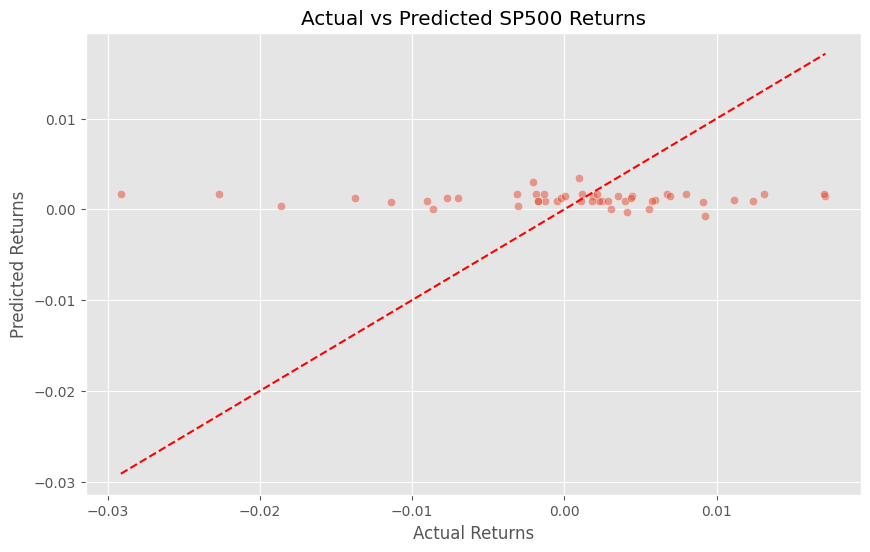

In [57]:
# Get the best model
best_model = aml.leader
print(f"Best Model: {best_model}")

# Performance on test set
perf = best_model.model_performance(test)
print(perf)

# Plotting Actual vs Predicted
predictions = best_model.predict(test)
pred_df = test.cbind(predictions)
pred_pd = pred_df.as_data_frame()

plt.figure(figsize=(10,6))
sns.scatterplot(x=pred_pd['SP500_Target'], y=pred_pd['predict'], alpha=0.5)
plt.title('Actual vs Predicted SP500 Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.plot([pred_pd['SP500_Target'].min(), pred_pd['SP500_Target'].max()],
         [pred_pd['SP500_Target'].min(), pred_pd['SP500_Target'].max()], 'r--')
plt.show()


Explanation:

H2O AutoML: Automatically trains multiple models (GBM, XGBoost, Deep Learning, etc.) and selects the best-performing one based on validation metrics.
Model Evaluation: The performance metrics (e.g., RMSE, MAE) help assess how well the model predicts unseen data.
Visualization: The scatter plot compares actual vs. predicted returns, with the ideal prediction lying on the red dashed line.

###Explainable AI: